## Importing and Defining

#### GRATING = 600ZD

In [168]:
import os
import math
import statistics
import numpy as np 
from astropy.io import fits 
from smooth_kevin import smoother
import py_specrebin
import matplotlib.pyplot as plt 
from matplotlib import rc
import py_specrebin
import pandas as pd
path_name = '.'


$\color{red}{\small{\text{Caution: Execute the following cell only once per run.}}}$
$\color{red}{\small{\text{Do not modify the }\texttt{std_out}\text{ or }\texttt{std_err}\text{ variables.}}}$
$\color{red}{\small{\text{If they are modified by accident, please restart the kernel and run the notebook from the beginning.}}}$

In [3]:
# Saving the original streams for stdout and stderr. To be used for logging output later
import sys
std_out = sys.stdout; std_err = sys.stderr

In [4]:
new_wave_600 = np.arange(4000, 11000, .65) 
new_wave_1200 = np.arange(6000, 11000, .33) 

In [5]:
def get_original_data(file_names,mask_name):
    
    tot_flux = []
    tot_wave = []
    tot_ivar = []
    
    for j in range(len(file_names)):
        #read in star data
        h_star = fits.open(path_name + '/' + 'data/{0}'.format(mask_name) + '/' + file_names[j], ignore_missing_end = True)
        data_star1 = h_star[1].data
        star_flux1 = data_star1['SKYSPEC'][0]
        star_wave1 = data_star1['LAMBDA'][0]
        star_ivar1 = data_star1['IVAR'][0]
        
        data_star2 = h_star[2].data
        star_flux2 = data_star2['SKYSPEC'][0]
        star_wave2 = data_star2['LAMBDA'][0]
        star_ivar2 = data_star2['IVAR'][0]
        
        
        #combine the blue and red side into one list
        star_flux = np.array(list(star_flux1) + list(star_flux2))
        star_wave = np.array(list(star_wave1) + list(star_wave2))
        star_ivar = np.array(list(star_ivar1) + list(star_ivar2))
        
        #add to above lists
        tot_flux.append(star_flux)
        tot_wave.append(star_wave)
        tot_ivar.append(star_ivar)

        h_star.close()
        
    return tot_flux, tot_wave, tot_ivar 

In [6]:
def rebin(fluxes, waves, ivar, grating):
    
    rbflux = []
    rbivar = []
    
    if grating == 600:
        new_wave = new_wave_600
    elif grating == 1200:
        new_wave = new_wave_1200
    
    for i in range(len(waves)):
        new_flux,new_ivar = py_specrebin.rebinspec(waves[i],fluxes[i],new_wave,ivar=ivar[i])
        new_flux_err = 1/np.sqrt(new_ivar)

        rbflux.append(new_flux)
        rbivar.append(new_ivar)
        
    return rbflux, new_wave, rbivar

In [7]:
def find_median(rebinned_flux_array):
    
    median_vals = []
    
    print(len(rebinned_flux_array))
    
    for i in range(len(rebinned_flux_array[0])):

        comp = []
        
        for array in rebinned_flux_array:
            
            if np.isfinite(array[i]) == True:
                comp.append(array[i])
                
        median_vals.append(np.median(comp))
        
    return median_vals

In [8]:
def get_exclusions():
    filepath = 'ISM_EM_LINES.txt'
    fp = open(filepath)
    all_data = []
    for line in (fp):
        mask_name = line.split(':')[0].split('_')[0]
        slit_number = line.split(':')[1].strip().split(" ")[0]
        if len(slit_number) == 2:
            slit_number = '0' + slit_number
        elif len(slit_number) == 1:
            slit_number = '00' + slit_number
        else:
            pass
        object_id = line.split(':')[1].strip().split()[1]
        data = {}
        data['mask_name'] = mask_name
        data['slit_number'] = slit_number
        data['object_id'] = object_id
        all_data.append(data)
    return all_data     

In [9]:
def get_files_to_include(folder):
    import os
    list_of_files_to_include = []
    list_of_files_to_exclude = []
    serendip_files = []
    all_file_names_in_folder = os.listdir('data/{}'.format(folder))
    y = len(all_file_names_in_folder)
    print("The number of files in the folder is {0}".format(y))
    all_data = get_exclusions()
    len_all_data = len(all_data)
    for n in range(y):
        parts_of_file_name = all_file_names_in_folder[n].split(".")
        if parts_of_file_name[0] == 'spec1d': # avoids hidden DS_Store files on my mac
            object_id = parts_of_file_name[3]
            slit_number = parts_of_file_name[2]
            mask_name = parts_of_file_name[1]
            should_include = True
            should_exclude = True
            for k in range(len_all_data):
                if ((object_id == all_data[k]['object_id']) and (slit_number == all_data[k]['slit_number']) and (mask_name == all_data[k]['mask_name'])):
                    should_include = False
                    should_exclude = True
                if 'serendip' in object_id:
                    should_include = False
                    should_exclude = False
            if should_include == True:
                list_of_files_to_include.append(all_file_names_in_folder[n])       
            elif should_exclude == True:
                list_of_files_to_exclude.append(all_file_names_in_folder[n])
            elif should_include == False & should_exclude == False:
                serendip_files.append(all_file_names_in_folder[n])
    
    print('The number of files left after exclusions is {0}'.format(len(list_of_files_to_include)))
    
    return sorted(list_of_files_to_include), sorted(list_of_files_to_exclude), sorted(serendip_files)


## Function to Save The Rebinned Data

In [10]:
#Sarthak's function as modified by Liv Gaunt
def exportToFits(rbflux, rbwave, rbivar, mask_name, file_names, incl_or_excl):

    for i in range(len(rbflux)):
            
        hdu1 = fits.PrimaryHDU() #primary HDU (empty)
        hdu1.header['INCLUDE'] = (incl_or_excl, 'Include in median calc if T') #this sets the tag for inclusion
            
        c1 = fits.Column(name='RBFLUX', array=rbflux[i], format='E')
        c2 = fits.Column(name='RBWAVE', array=rbwave, format='E') #no [i] on rbwave since it's just one array
        c3 = fits.Column(name='RBIVAR', array=rbivar[i], format='E')
        hdu2 = fits.BinTableHDU.from_columns([c1, c2, c3]) #first extensional HDU (w data)
            
        hdul = fits.HDUList([hdu1, hdu2]) #combine both HDUs into file and write it below
            
        #this part puts the files to include in one folder, and those to exclude in another
        if incl_or_excl == True:
            hdul.writeto(path_name + '/{0}_Rebinned/{0}_Included'.format(mask_name) + '/' + 'rebinned_{0}'.format(file_names[i]))
            
        elif incl_or_excl == False:
            hdul.writeto(path_name + '/{0}_Rebinned/{0}_Excluded'.format(mask_name) + '/' + 'rebinned_{0}'.format(file_names[i]))
                
        else:
            hdul.writeto(path_name + '/{0}_Rebinned/{0}_Serendip'.format(mask_name) + '/' + 'rebinned_{0}'.format(file_names[i]))


## Function to Read FITS File and Get Back Rebin Data

In [11]:
def get_fits_rebinned_data (mask_name, file_names, incl_or_excl):
    if incl_or_excl == True:
        
        #all of these are libraries
        
        rbflux = []
        rbwave = []
        rbivar = []
        
        for slit in file_names: 
            rb_fits_include = fits.open(path_name + "/{0}_Rebinned/{0}_Included/rebinned_{1}".format(mask_name,slit))
            rbflux.append(rb_fits_include[1].data["RBFLUX"])
            rbwave.append(rb_fits_include[1].data["RBWAVE"])
            rbivar.append(rb_fits_include[1].data["RBIVAR"])
            
    elif incl_or_excl == False: 
        
        rbflux = []
        rbwave = []
        rbivar = []
        
        for slit in file_names: 
            rb_fits_include = fits.open(path_name + "/{0}_Rebinned/{0}_Excluded/rebinned_{1}".format(mask_name,slit))
            rbflux.append(rb_fits_include[1].data["RBFLUX"])
            rbwave.append(rb_fits_include[1].data["RBWAVE"])
            rbivar.append(rb_fits_include[1].data["RBIVAR"]) 
        
    else: 
        
        rbflux = []
        rbwave = []
        rbivar = []
        
        for slit in file_names: 
            rb_fits_include = fits.open(path_name + "/{0}_Rebinned/{0}_Serendip/rebinned_{1}".format(mask_name,slit))
            rbflux.append(rb_fits_include[1].data["RBFLUX"])
            rbwave.append(rb_fits_include[1].data["RBWAVE"])
            rbivar.append(rb_fits_include[1].data["RBIVAR"]) 
        
    return rbflux, rbwave, rbivar

## Function to Save The Median

In [12]:
def exportToFitsMedian(median,mask_name):
    
    hdu1 = fits.PrimaryHDU()
        
    c1 = fits.Column(name='MEDIAN',array=median,format="E")
    hdu2 = fits.BinTableHDU.from_columns([c1])
        
    hdul = fits.HDUList([hdu1,hdu2])
        
    hdul.writeto(path_name + '/{0}_Median/Median_of_{0}.fits.gz'.format(mask_name))

## Function To Read and Get Back Median

In [13]:
def get_med_from_fits(mask_name):
    median_read = fits.open(path_name + '/{0}_Median/Median_of_{0}.fits.gz'.format(mask_name))
    median_fits = median_read[1].data["MEDIAN"] #contain the median 
    return median_fits

## Median Airglow Subtraction


In [14]:
def median_subtraction(slit_index,rebinned_flux):
    
    new_flux = []
    
    spectrum = rebinned_flux[slit_index]
   
    for i in range(len(spectrum)):
        if np.isfinite(spectrum[i]) == True:
            new_flux.append(spectrum[i] - median[i])
        else:
            new_flux.append(spectrum[i])
            
    return new_flux

In [15]:
def get_slit_nums(files):
    
    slit_nums = []
    
    if len(files) > 1:
    
        for i in range(len(files)):
            parts_of_file_name = files[i].split(".")
            slit_num = parts_of_file_name[2]
            slit_nums.append(int(slit_num))
            
    return slit_nums

In [16]:
def find_slit_index(slit_nums,slit_num): 
    #print('The index of slit number {} is: '.format(slit_num), slit_nums.index(slit_num))
    return slit_nums.index(slit_num)

In [17]:
def plotting(mask_name, slit_nums, rebinned_flux, median, incl_or_excl):
    
    if incl_or_excl == True:
        for slit in slit_nums:
            slit_index = find_slit_index(slit_nums,slit)
            new_flux = median_subtraction(slit_index,rebinned_flux)
            fig,axs = plt.subplots(1)
            fig.patch.set_alpha(1)
            plt.ylim(-10000,10000) #could try getting a smaller y limit and getting rid of legend
            plt.xlim(4000,11000)
            #plt.plot(wave_all[slit_index], flux_all[slit_index], color = 'r', label = 'original')
            plt.plot(new_wave_600, median, scalex=False, scaley=False, color = 'r', label = 'median')
            plt.plot(new_wave_600, rebinned_flux[slit_index] + 4000, scalex=False, scaley=False, color = 'b', label = 'rebinned')
            plt.plot(new_wave_600, np.array(new_flux) + 8000, scalex=False, scaley=False, color = 'g', label = 'median subtracted')
            plt.title('{} Slit {}'.format(mask_name, slit))
            plt.xlabel('Wavelength')
            plt.ylabel('Flux')
            plt.legend()
            fig.savefig('{0}_Spectra/{0}_Included/{0} Slit {1}'.format(mask_name, slit)) #folder name would need to change for each mask
    else:
        for slit in slit_nums:
            slit_index = find_slit_index(slit_nums,slit)
            new_flux = median_subtraction(slit_index,rebinned_flux)
            fig,axs = plt.subplots(1)
            fig.patch.set_alpha(1)
            plt.ylim(-10000,10000) #could try getting a smaller y limit and getting rid of legend
            plt.xlim(4000,11000)
            #plt.plot(wave_all[slit_index], flux_all[slit_index], color = 'r', label = 'original')
            plt.plot(new_wave_600, median, scalex=False, scaley=False, color = 'r', label = 'median')
            plt.plot(new_wave_600, rebinned_flux[slit_index] + 4000, scalex=False, scaley=False, color = 'b', label = 'rebinned')
            plt.plot(new_wave_600, np.array(new_flux) + 8000, scalex=False, scaley=False, color = 'g', label = 'median subtracted')
            plt.title('{} Slit {}'.format(mask_name, slit))
            plt.xlabel('Wavelength')
            plt.ylabel('Flux')
            plt.legend()
            fig.savefig('{0}_Spectra/{0}_Excluded/{0} Slit {1}'.format(mask_name, slit)) #folder name would need to change for each mask

## Looking At Specific Slit

In [18]:
def one_slit(slit_number,rebinned_flux,median,incl_or_excl,multiplier,
             min_ylim,max_ylim,min_xlim,max_xlim): #combination of median_subtraction + plotting function 
#slit_number, rebinned_flux, and incl_excl will need to be changed depending on whether we want to look at incl or excl 
    if incl_or_excl == True: #median subtraction 
        new_flux = [] #sky subtracted spectra 
        slit_index = find_slit_index(slit_nums,slit_number)
        spectrum = rebinned_flux[slit_index]
        multiplier = multiplier 

        for i in range(len(spectrum)):
            if np.isfinite(spectrum[i]) == True:
                new_flux.append((spectrum[i]*multiplier) - median[i]) 
            else:
                new_flux.append(spectrum[i])

        #plotting 
        fig,axs = plt.subplots(1)
        plt.ylim(-10000,10000) #could try getting a smaller y limit and getting rid of legend
        plt.xlim(4000,11000)
        plt.plot(new_wave_600, median, c="r", scalex=False, scaley=False, label = "median")
        plt.plot(new_wave_600, rebinned_flux[slit_index] + 5000, c="b", scalex=False, scaley=False, label = "rebinned")
        #plt.plot(new_wave_600, rebinned_flux["slit_{}".format(slit_number)] - 0.9*median + 8000, scalex=False, scaley=False,
                #label = "subtracted") #error
        plt.plot(new_wave_600, np.array(new_flux), c="g", scalex=False, scaley=False,label = "subtracted")
        plt.xlabel("Wavelength (A)")
        plt.ylabel("Flux (Electron/Hour)")
        plt.title("Slit #{}".format(slit_number))
        
    else:
        new_flux = [] #sky subtracted spectra w/ scaling
        new_flux_no_scaling = [] #sky subtracted spectra w/o scaling
        rbflux_with_scaling = []
        slit_index = find_slit_index(slit_nums_exclude,slit_number) #changed slit_nums to slit_nums_exclude
        spectrum = rebinned_flux[slit_index] #rbflux w/ no scaling
        multiplier = multiplier 

        #multiplying the rbflux by scaling factor 
        for i in range(len(spectrum)):
            if np.isfinite(spectrum[i]) == True:
                new_flux.append((spectrum[i] * multiplier) - median[i]) 
                rbflux_with_scaling.append((spectrum[i] * multiplier))
            else:
                new_flux.append(spectrum[i])
                rbflux_with_scaling.append(spectrum[i])

        #no scaling factor
        for i in range(len(spectrum)):
            if np.isfinite(spectrum[i]) == True:
                new_flux_no_scaling.append((spectrum[i]) - median[i]) 
            else:
                new_flux_no_scaling.append(spectrum[i])
        
        #plotting 
        fig,axs = plt.subplots(1)
        plt.ylim(min_ylim,max_ylim) #could try getting a smaller y limit and getting rid of legend
        plt.xlim(min_xlim,max_xlim)
        plt.plot(new_wave_600, median, c="r", scalex=False, scaley=False, label = "median")
        plt.plot(new_wave_600, rbflux_with_scaling, c="b", scalex=False, scaley=False, label = "rebinned w/ scaling")
        plt.plot(new_wave_600, np.array(new_flux_no_scaling), c="purple", scalex=False, scaley=False, label = "Subtracted w/o scaling")
        plt.plot(new_wave_600, np.array(new_flux), c="g", scalex=False, scaley=False,label = "subtracted")
        plt.xlabel("Wavelength (A)")
        plt.ylabel("Flux (Electron/Hour)")
        plt.title("Slit #{}".format(slit_number) + "/Multiplier: {}".format(multiplier) 
                  + "/From {0} to {1}".format(min_xlim,max_xlim))
        

## Define The Mask

In [19]:
mask_name = "C1M33P" #change to fit the appropriate mask 

## Getting Files We Want to Include and Exclude

In [20]:
#filtering files
list_of_files_to_include, list_of_files_to_exclude, list_of_serendip_files = get_files_to_include(mask_name)

#sorted
#file_names = all slits used to create the median (airglow)
#file_names_exclude = all slits that contain ISM emission lines 
#file_names_serendip = all serendip files
#file_names_all = all slits excluding "serendip"

file_names = list_of_files_to_include
file_names_exclude = list_of_files_to_exclude
file_names_serendip = list_of_serendip_files
file_names_all = list_of_files_to_include + list_of_files_to_exclude

The number of files in the folder is 245
The number of files left after exclusions is 73


## Extracting The Wavelength, Flux, and Inverse Variance

Make sure to comment out the codes in this section after you have rebinned and saved your data!!!

Then make sure to uncomment them whenever you're working with a new mask and want to rebin!!!

In [21]:
#getting data
#try getting and rebinning all files
flux, wave, ivar= get_original_data(file_names, mask_name) 

In [111]:
#rebinning the original data
rbflux, rbwave, rbivar = rebin(flux, wave, ivar, 600) # this takes about 4 minutes to run

In [22]:
#getting all excluded data
flux_exclude, wave_exclude, ivar_exclude = get_original_data(file_names_exclude, mask_name)

In [112]:
#rebinning the excluded data
rbflux_exclude, rbwave_exclude, rbivar_exclude = rebin(flux_exclude, wave_exclude, ivar_exclude, 600)

In [24]:
#getting all serendip data 
#NOTE: we will never use it but is good to just process it
flux_serendip, wave_serendip, ivar_serendip = get_original_data(list_of_serendip_files, mask_name)

In [25]:
#rebinning the serendip data
rbflux_serendip, rbwave_serendip, rbivar_serendip = rebin(flux_serendip, wave_serendip, ivar_serendip, 600)

## Saving The Rebinned Data

In [26]:
paths = [#make three folders to store the rebinned data, the median, and the spectra
        "./{}_Rebinned".format(mask_name),
        "./{}_Spectra".format(mask_name),
        "./{}_Median".format(mask_name),

        #make sub-folders for rebinned data
        "./{0}_Rebinned/{0}_Excluded".format(mask_name),
        "./{0}_Rebinned/{0}_Included".format(mask_name),
        "./{0}_Rebinned/{0}_Serendip".format(mask_name),

        #make sub-folders for the spectra
        "./{0}_Spectra/{0}_Excluded".format(mask_name),
        "./{0}_Spectra/{0}_Included".format(mask_name),

        #make directory to stores the scaled flux and shifted wavelength and polynomial coefficients
        "./{0}_Rebinned/{0}_Scale_Values".format(mask_name),
        "./{0}_Rebinned/{0}_Shift_Values".format(mask_name),
        "./{0}_Rebinned/{0}_Polynomial_Coefficients".format(mask_name),

        #make sub-folders for scaling and shiftingfFactors and rebinned flux w/ shifted wavelength
        "./{0}_Rebinned/{0}_Scaling_and_Shifting_Factor".format(mask_name),
        "./{0}_Rebinned/{0}_Rebinned_Flux_Shifted_Wave".format(mask_name),

        #make directories to stores final trimmed spectra
        "./{0}_Trimmed_Spectra".format(mask_name),
        "./{0}_Trimmed_Spectra/Excluded".format(mask_name),
        "./{0}_Trimmed_Spectra/Included".format(mask_name),
        "./{0}_Trimmed_Spectra/Optimized_Spectrum_Flux".format(mask_name),

        #make directories to stores polynomial fits and factor vs RMS plots
        "./{0}_Polynomial_Graph".format(mask_name),
        "./{0}_Polynomial_Graph/Scaling_vs_RMS".format(mask_name),
        "./{0}_Polynomial_Graph/Shifting_vs_RMS".format(mask_name),
        "./{0}_Polynomial_Graph/Scaling_Fitting".format(mask_name),
        "./{0}_Polynomial_Graph/Shifting_Fitting".format(mask_name)]

for path in paths:
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise

In [27]:
exportToFits(rbflux, rbwave, rbivar, mask_name, file_names, True) 
exportToFits(rbflux_exclude, rbwave_exclude, rbivar_exclude, mask_name, file_names_exclude, False)
exportToFits(rbflux_serendip, rbwave_serendip, rbivar_serendip, mask_name, file_names_serendip, None)

## Reading Back The Rebinned Data

In [23]:
rbflux_fits,rbwave_fits,rbivar_fits = get_fits_rebinned_data(mask_name,file_names,True)
rbflux_fits_exclude,rbwave_fits_exclude,rbivar_fits_exclude = get_fits_rebinned_data(mask_name,file_names_exclude,False)
rbflux_fits_serendip,rbwave_fits_serendip,rbivar_fits_serendip = get_fits_rebinned_data(mask_name,file_names_serendip,None)

## Finding The Median 

In [24]:
#taking the median
median = find_median(rbflux_fits) #median length is 10770 (M33D2A)

73


## Saving Median As FITS

In [30]:
exportToFitsMedian(median,mask_name)

## Getting Back Median From FITS

In [25]:
median_fits = get_med_from_fits(mask_name)

## Slits to Include and Exclude

In [26]:
slit_nums = get_slit_nums(file_names)
slit_nums_exclude = get_slit_nums(file_names_exclude)

all_slit_nums = get_slit_nums(file_names_all)

print("Slit # to INCLUDE in median calculation: {0}".format(slit_nums))
print("Slit # to EXCLUDE: {0}".format(slit_nums_exclude))

Slit # to INCLUDE in median calculation: [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 25, 26, 28, 29, 30, 31, 32, 34, 35, 38, 39, 46, 50, 54, 57, 61, 63, 65, 66, 69, 75, 78, 80, 83, 86, 90, 94, 96, 103, 104, 105, 106, 107, 111, 114, 115, 118, 134, 135, 141, 150, 157, 168, 173, 174, 175, 178, 180, 183, 188, 189, 194, 196, 198, 200]
Slit # to EXCLUDE: [0, 9, 16, 23, 24, 33, 36, 37, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 55, 56, 58, 62, 64, 67, 68, 71, 72, 73, 74, 76, 77, 79, 81, 82, 84, 85, 87, 88, 89, 91, 92, 93, 95, 97, 99, 100, 101, 102, 108, 109, 110, 112, 113, 116, 117, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 136, 137, 138, 140, 142, 143, 144, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 164, 165, 166, 167, 169, 172, 176, 177, 185, 186, 187, 191, 192, 193, 195, 199]


## Plotting ALL Slits In A Mask and Saving It In A Folder

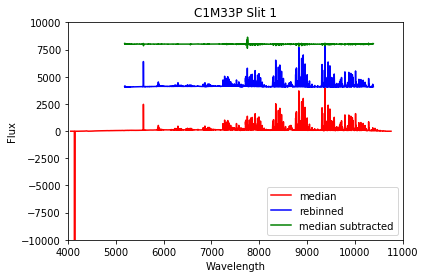

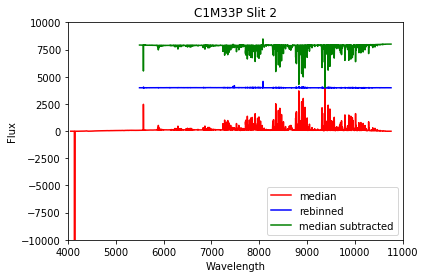

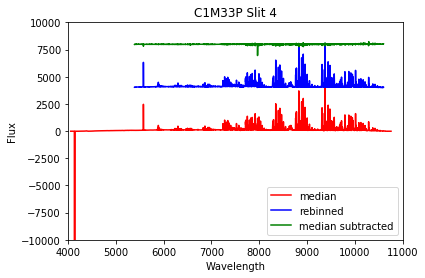

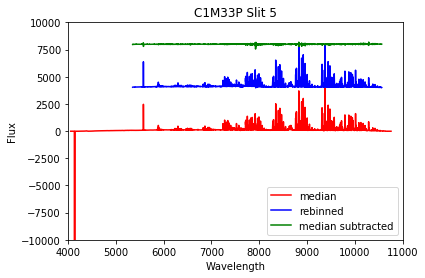

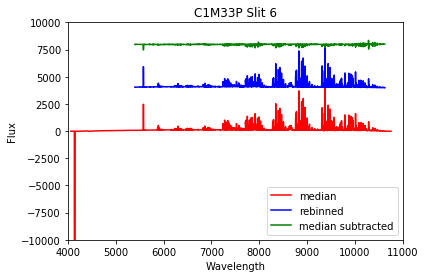

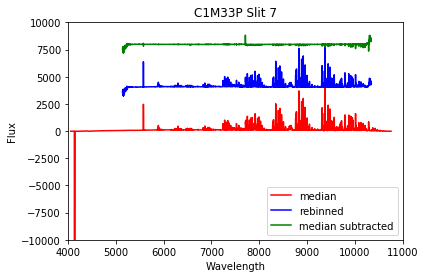

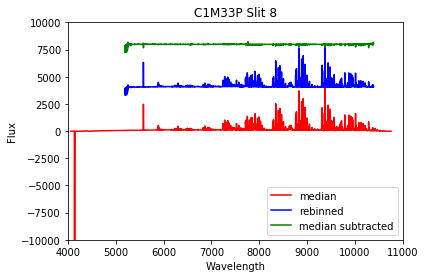

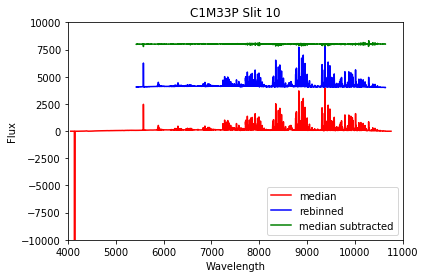

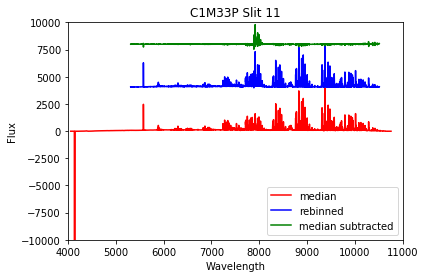

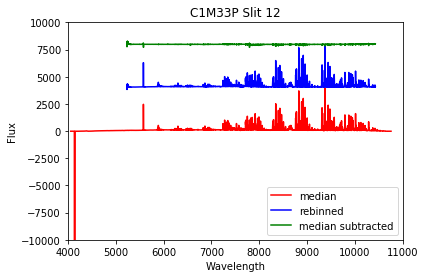

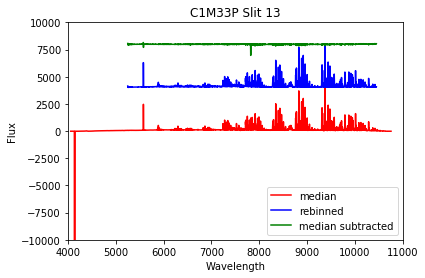

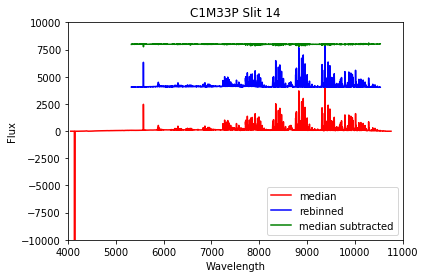

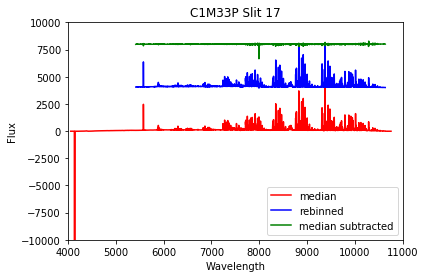

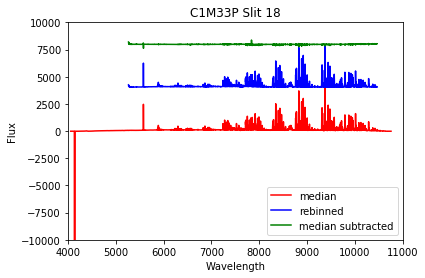

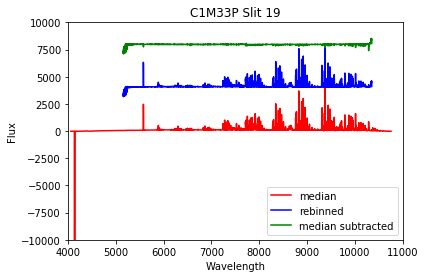

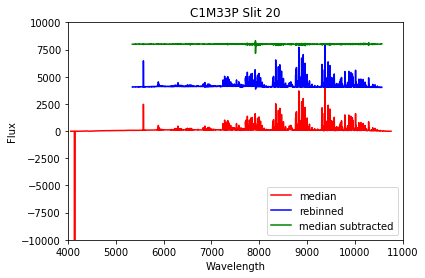

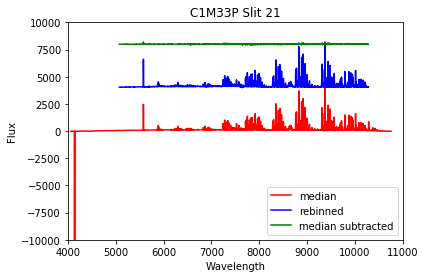

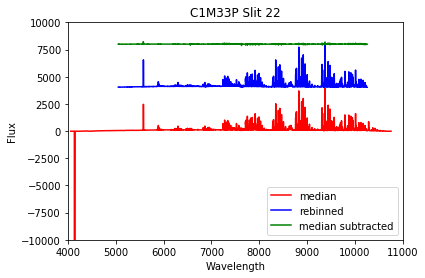

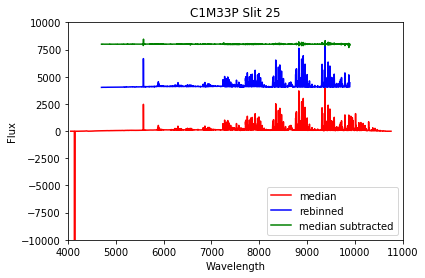

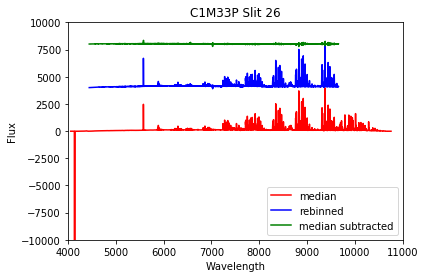

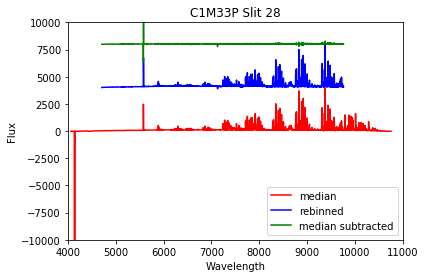

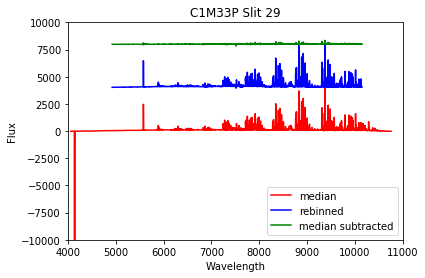

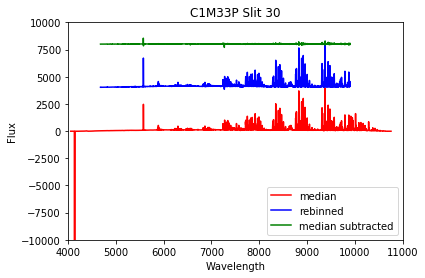

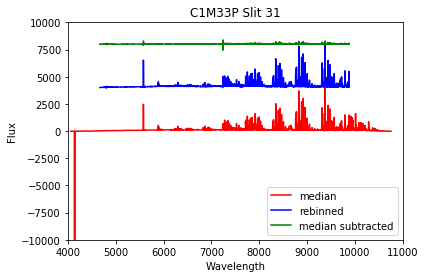

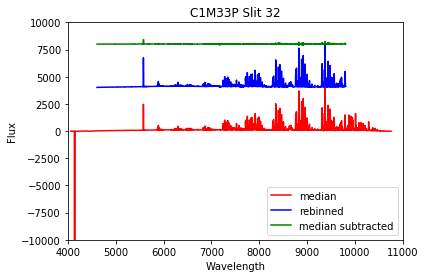

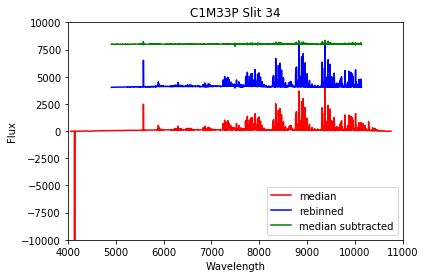

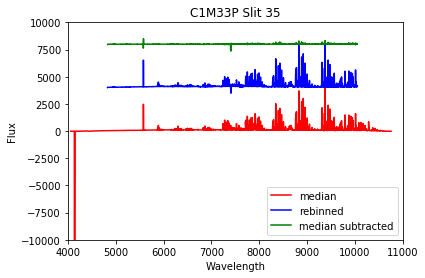

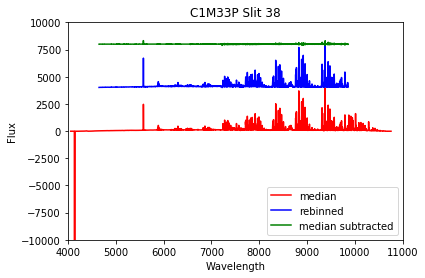

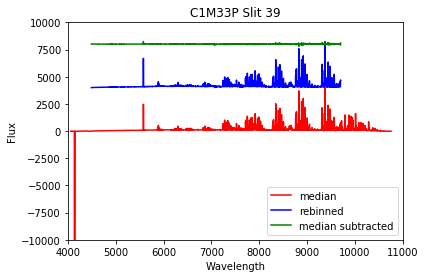

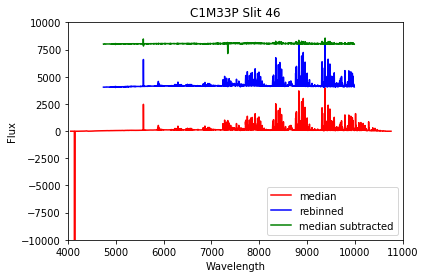

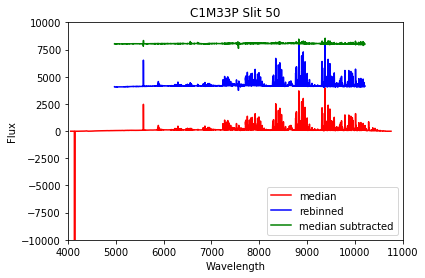

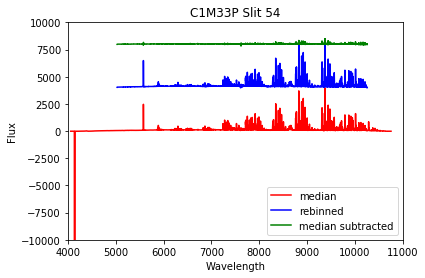

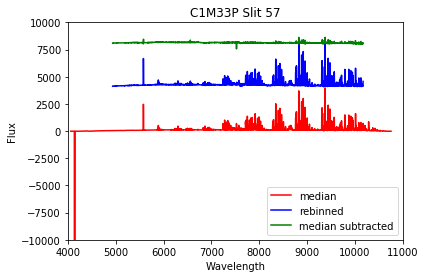

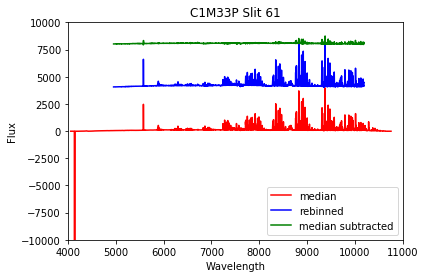

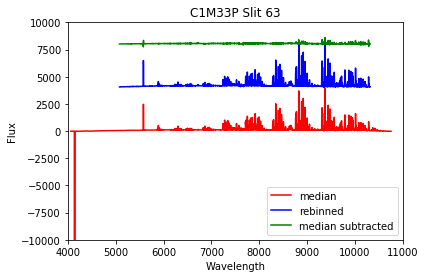

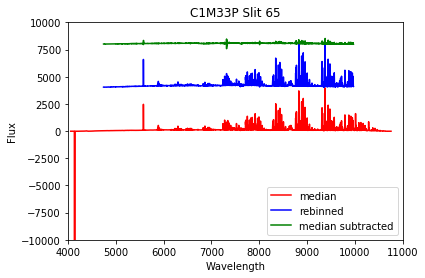

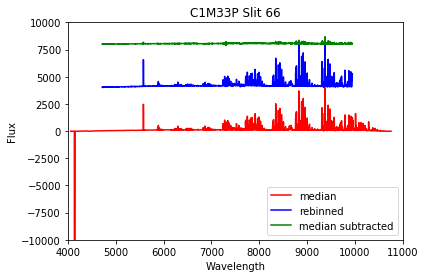

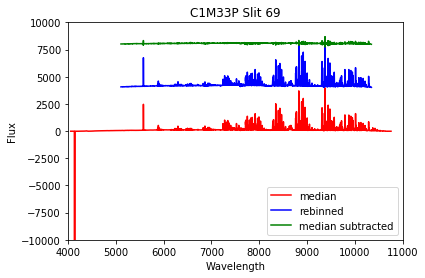

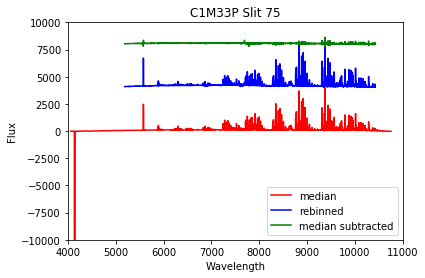

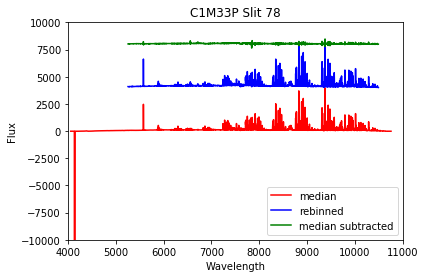

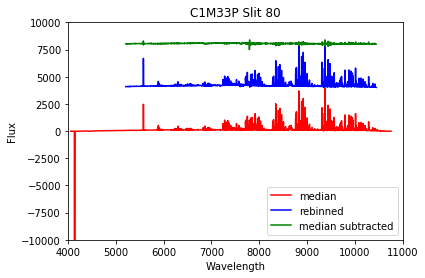

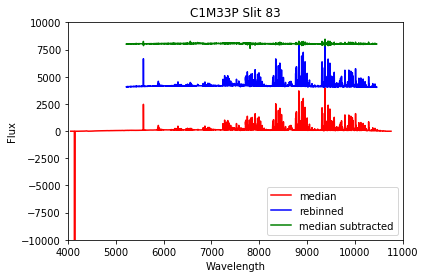

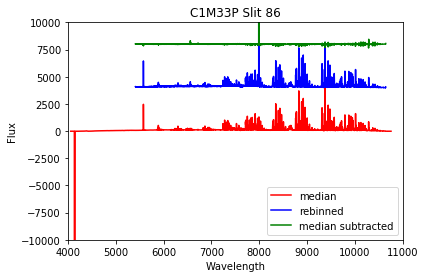

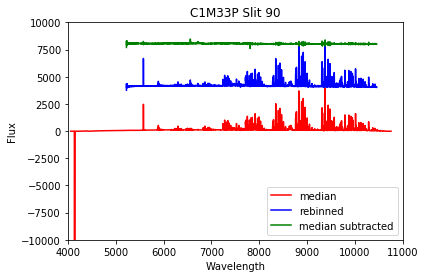

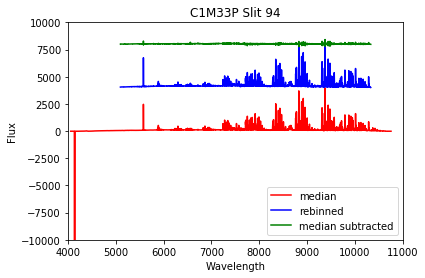

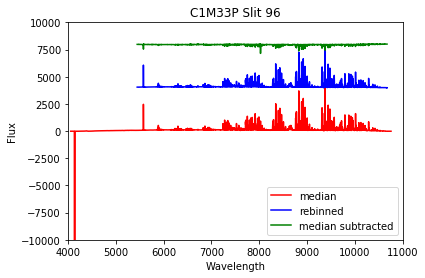

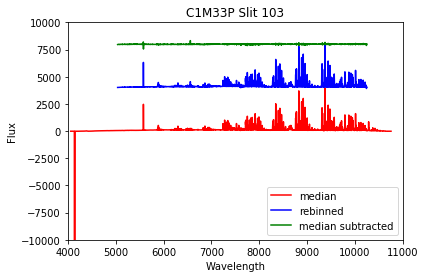

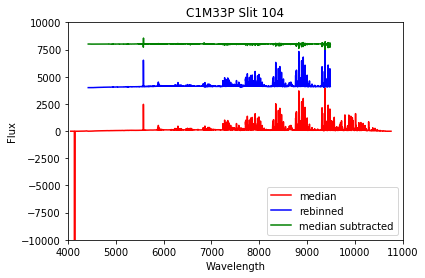

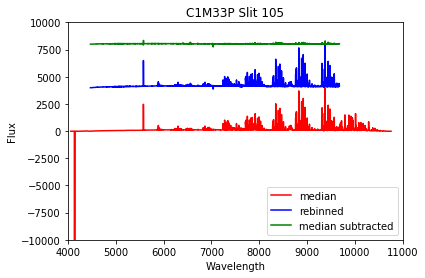

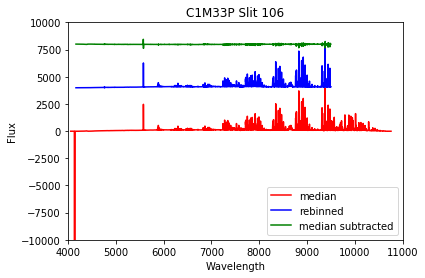

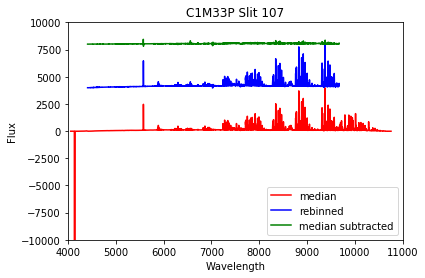

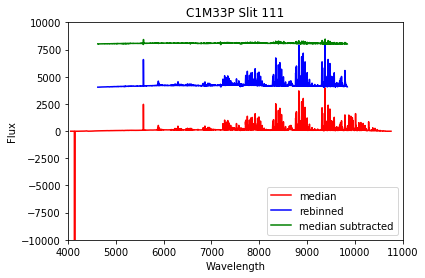

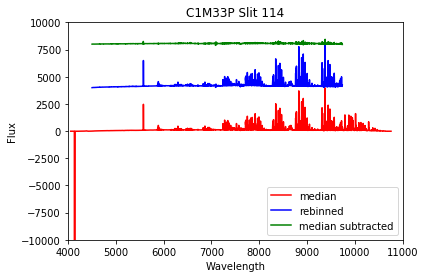

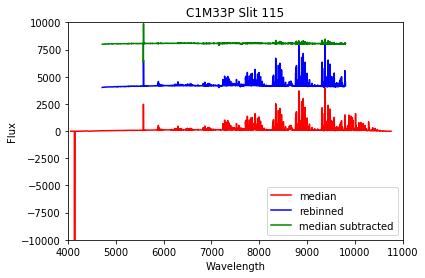

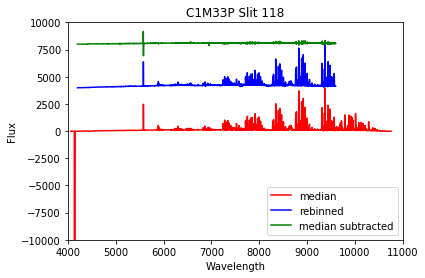

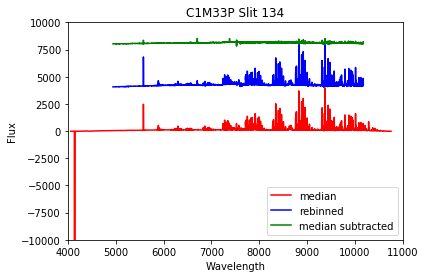

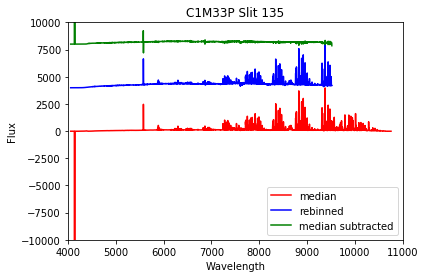

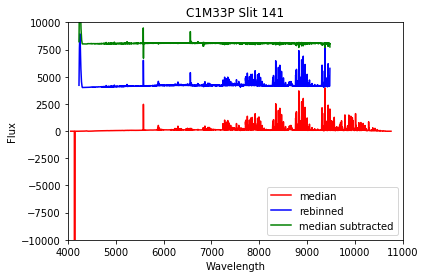

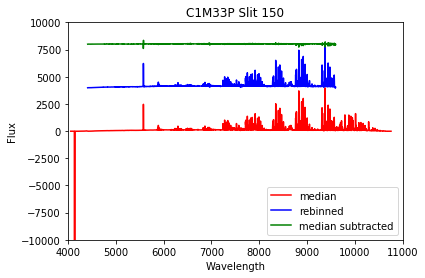

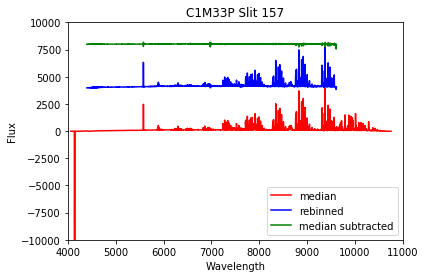

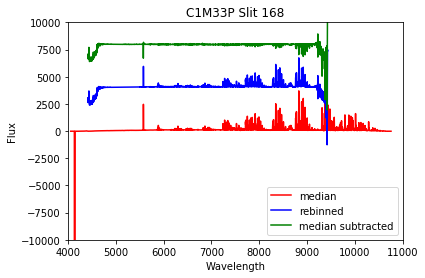

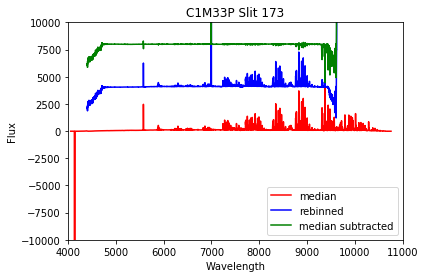

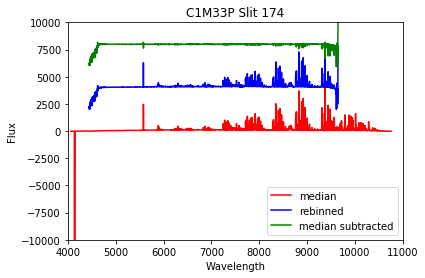

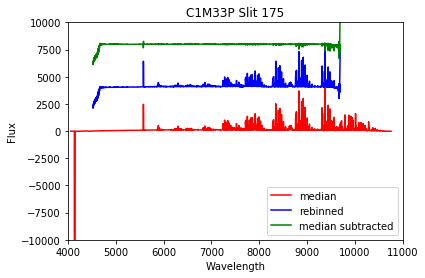

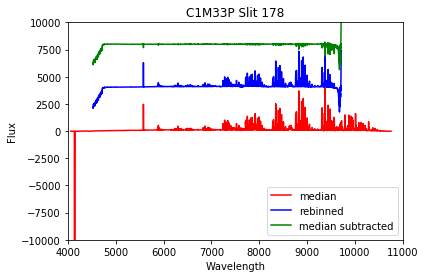

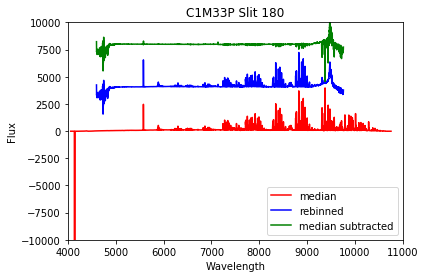

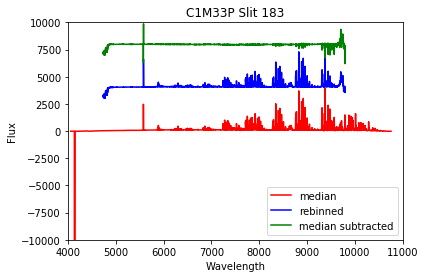

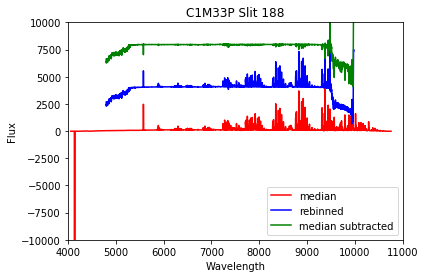

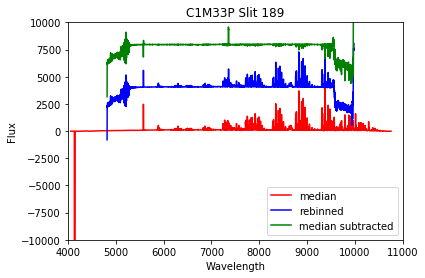

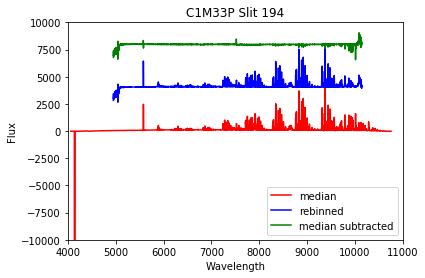

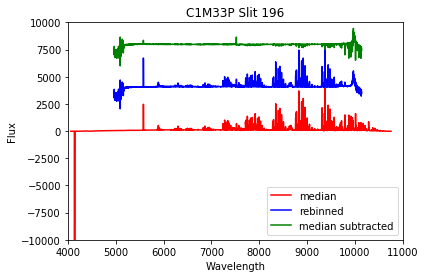

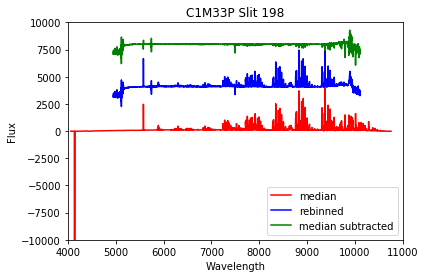

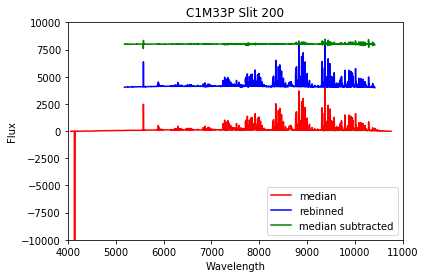

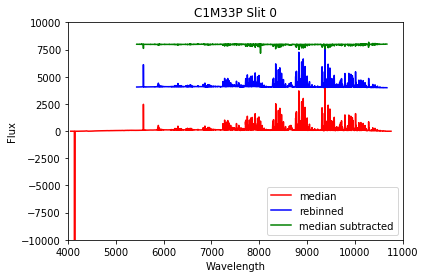

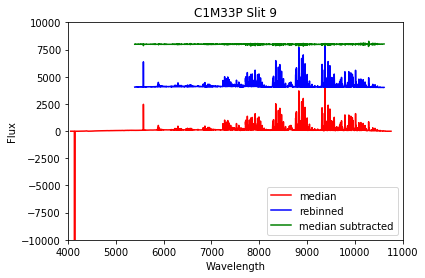

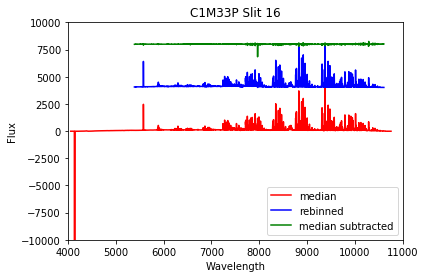

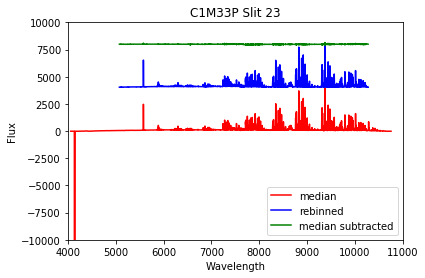

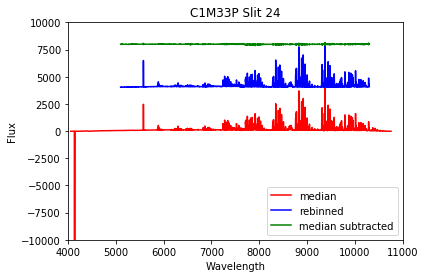

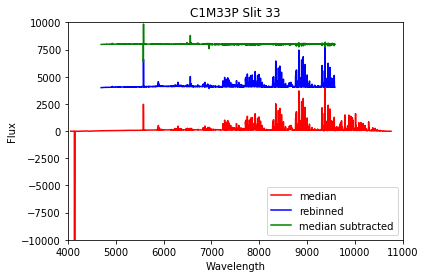

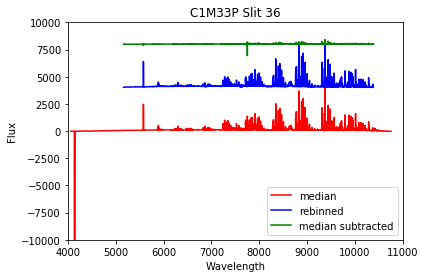

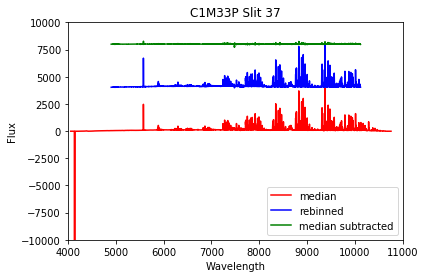

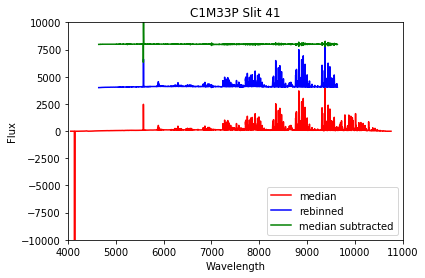

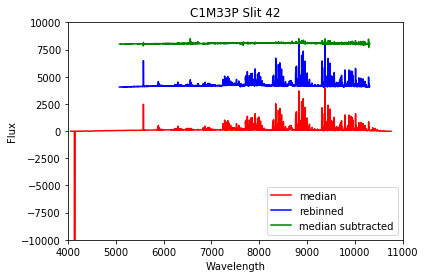

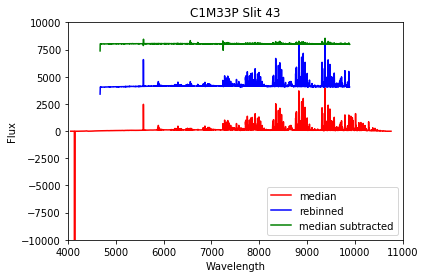

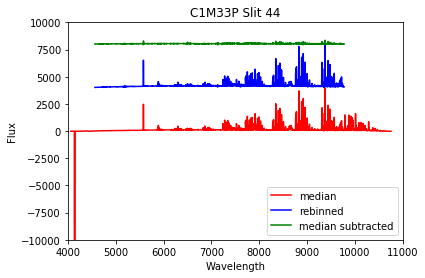

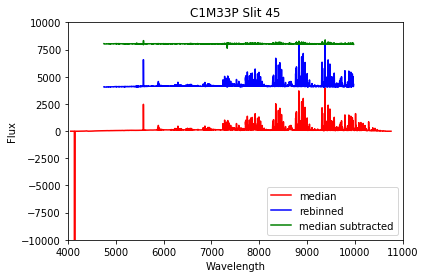

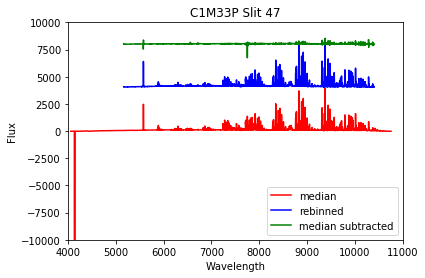

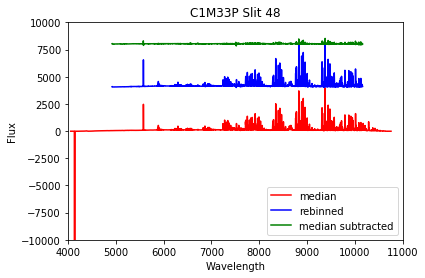

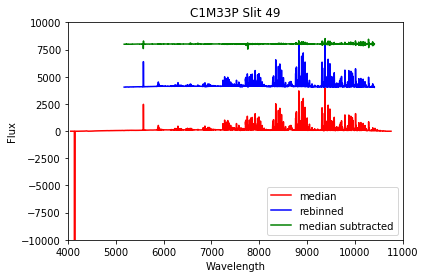

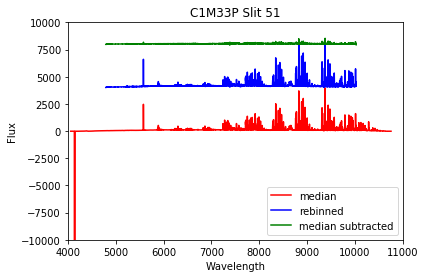

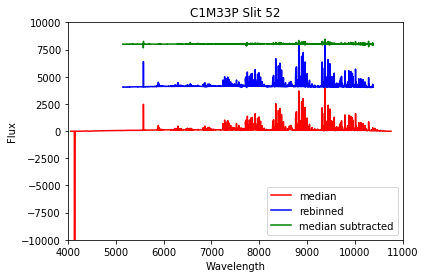

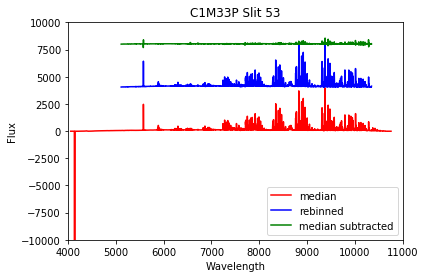

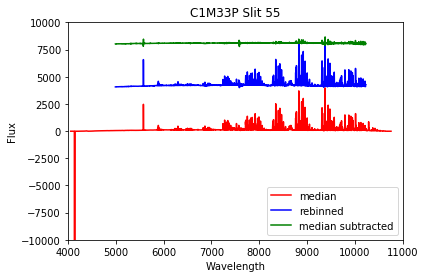

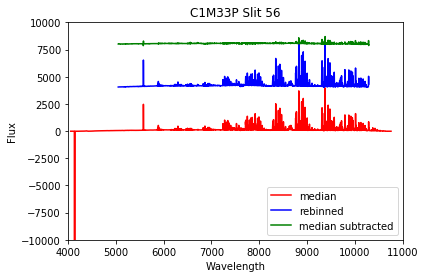

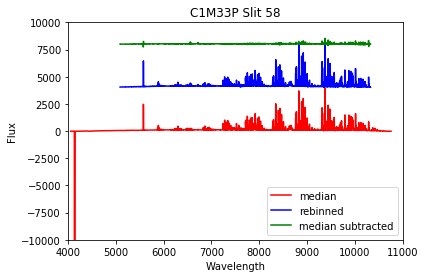

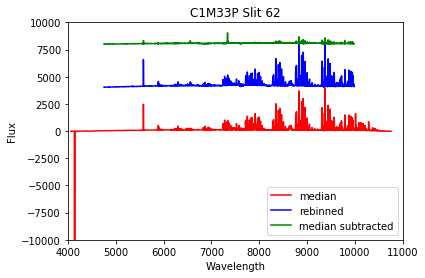

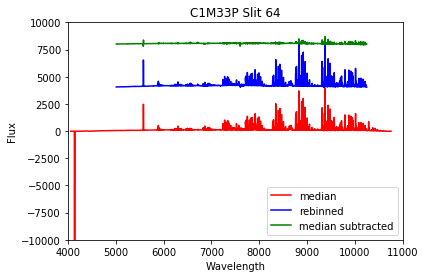

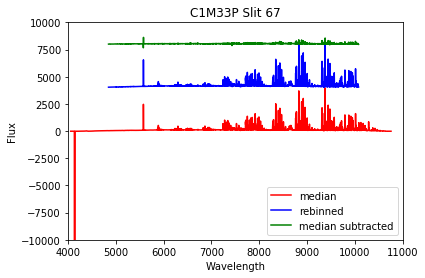

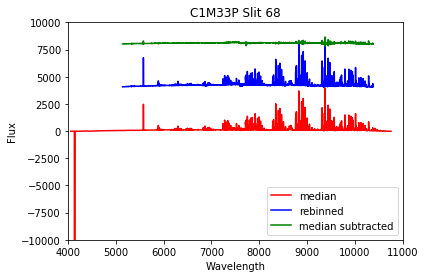

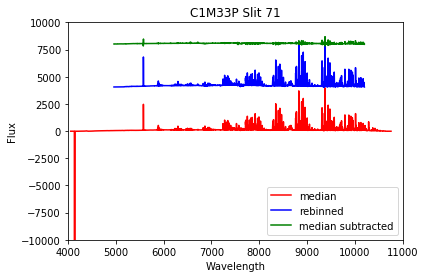

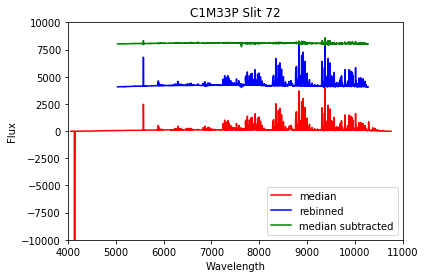

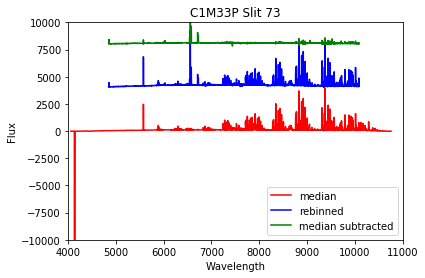

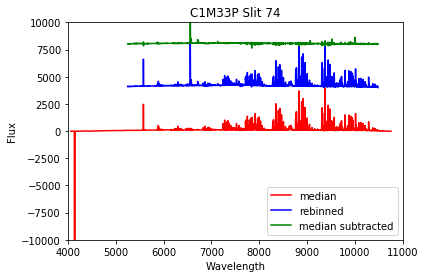

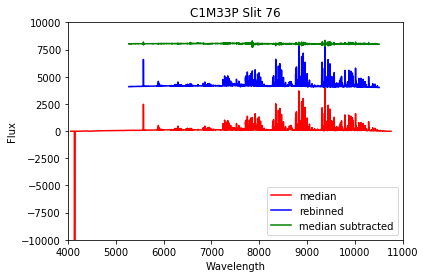

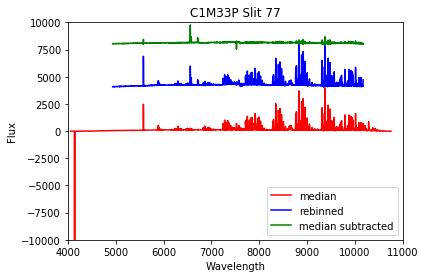

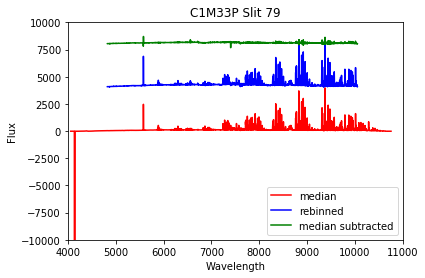

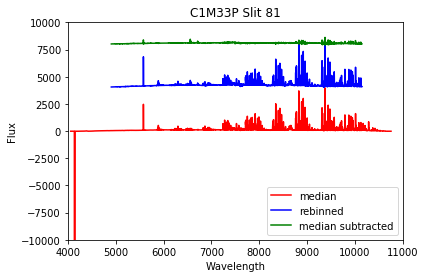

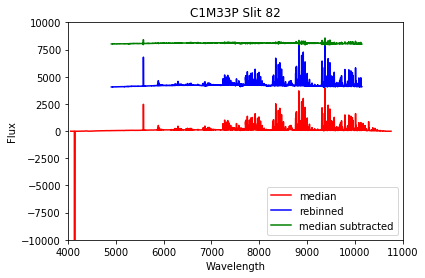

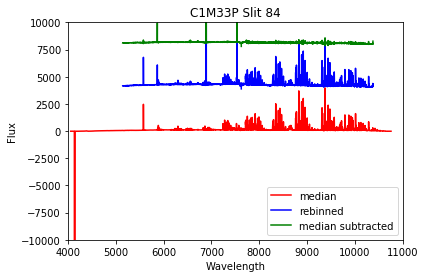

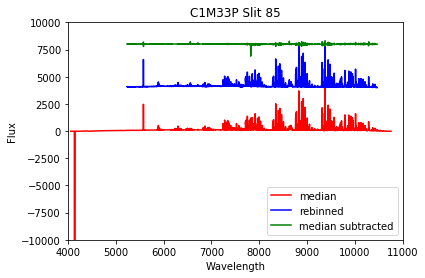

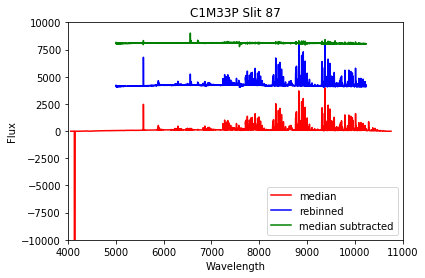

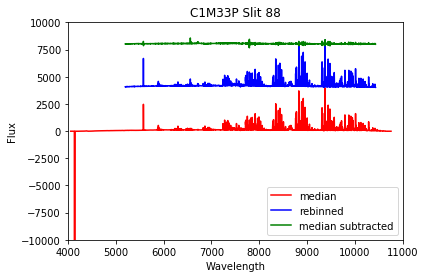

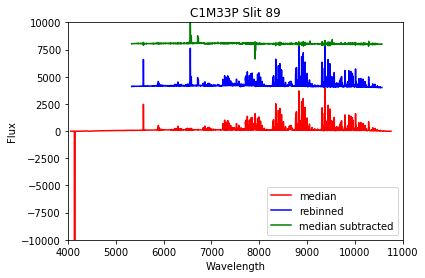

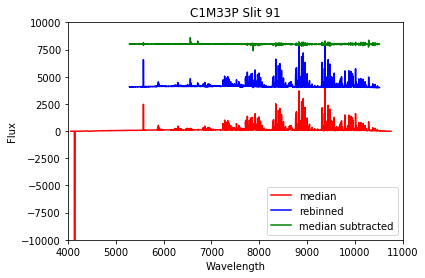

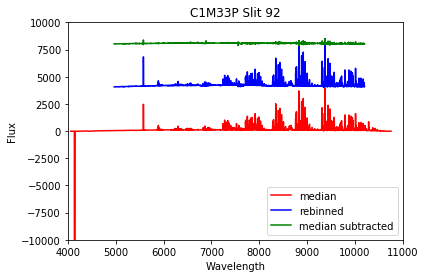

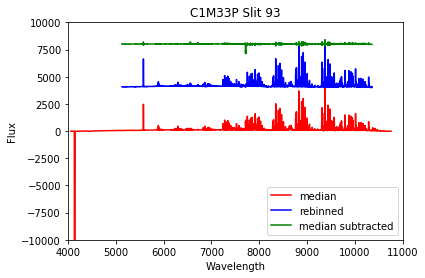

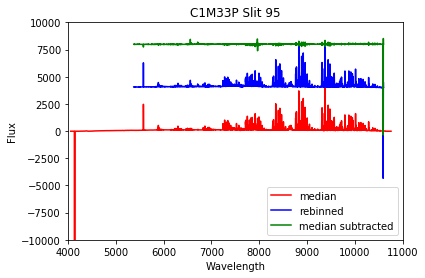

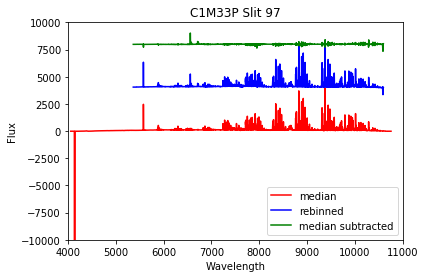

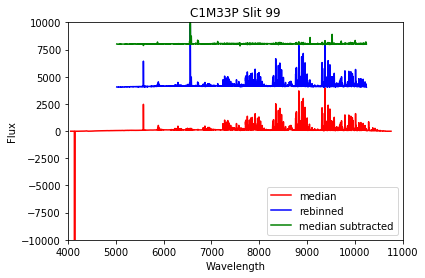

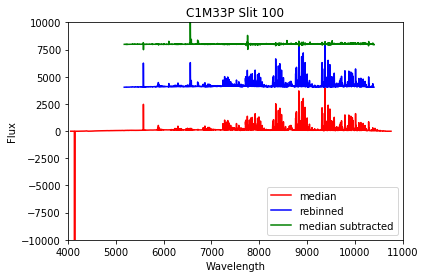

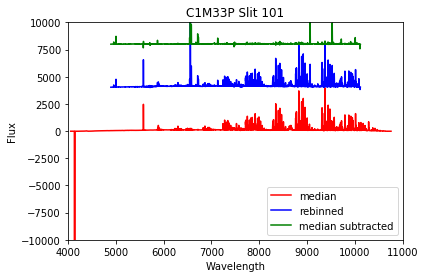

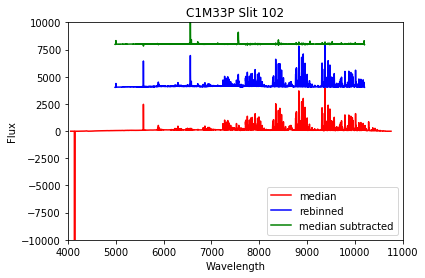

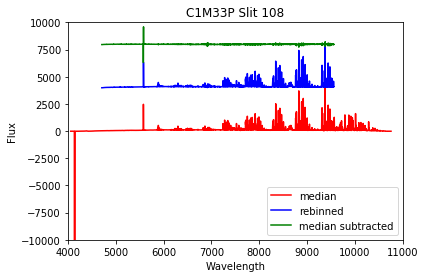

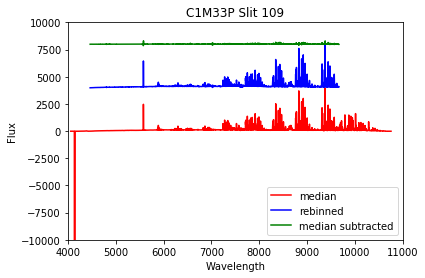

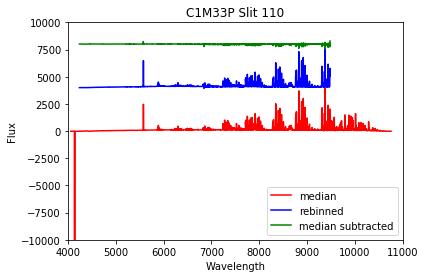

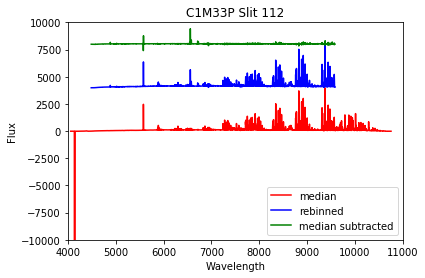

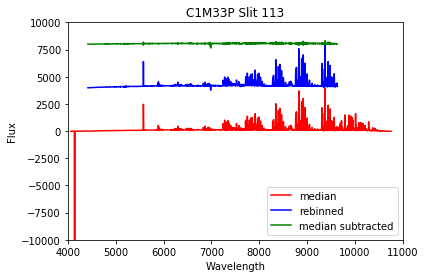

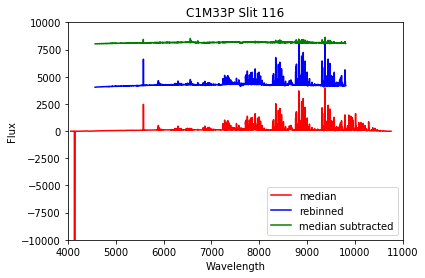

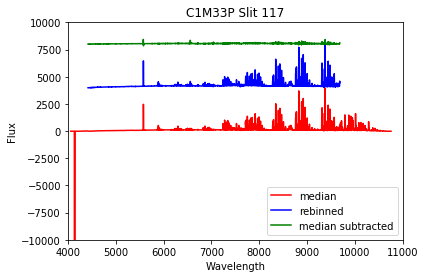

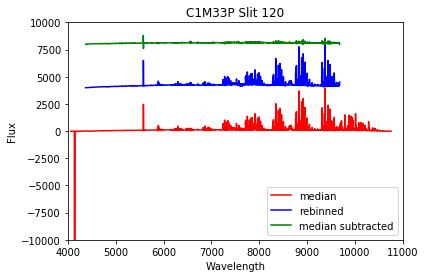

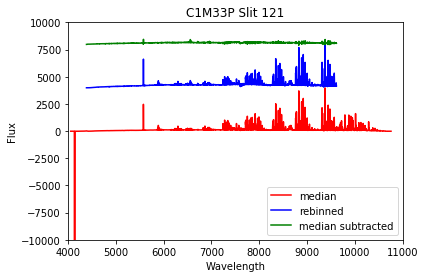

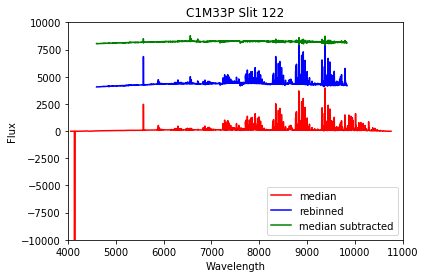

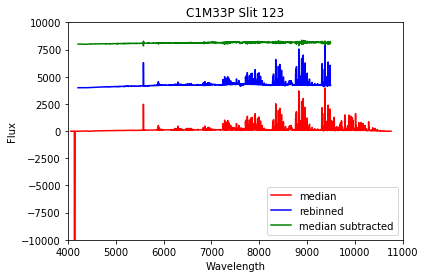

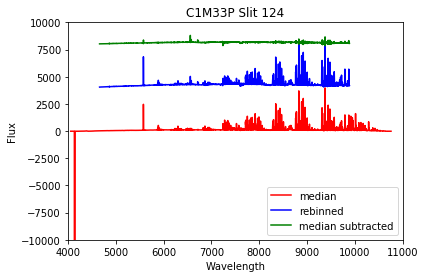

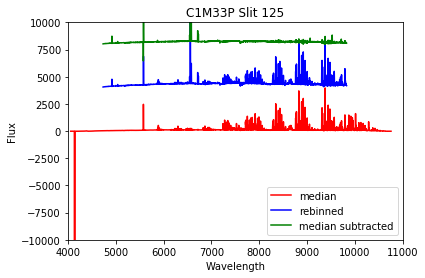

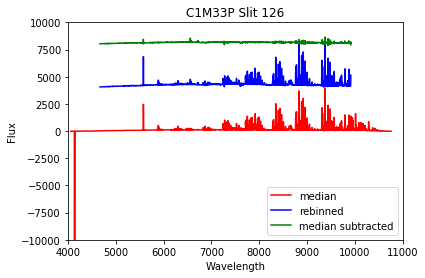

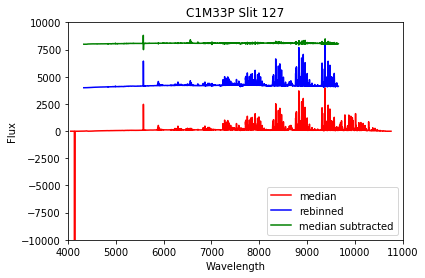

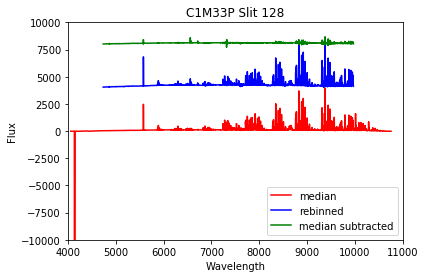

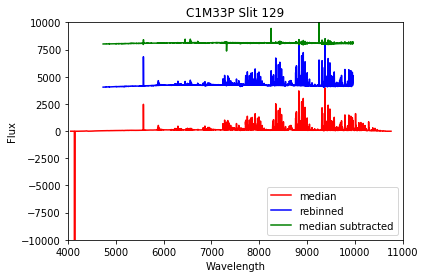

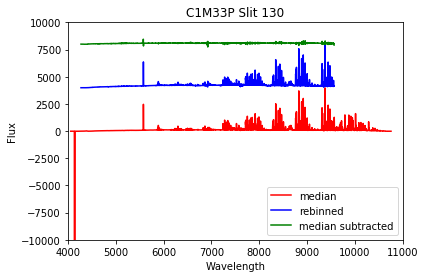

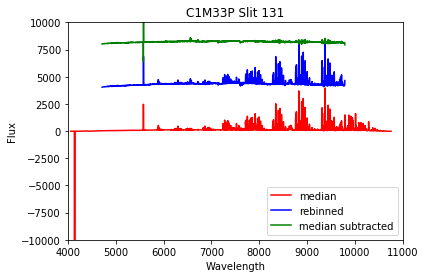

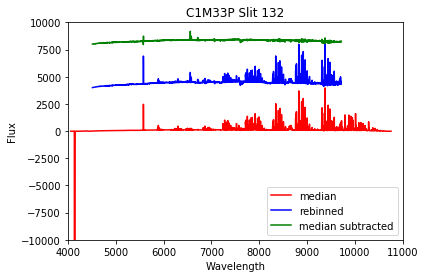

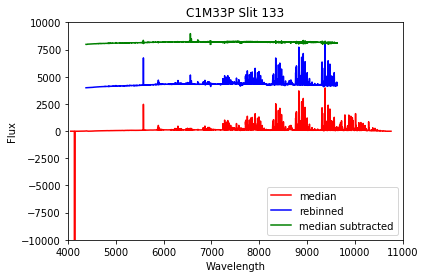

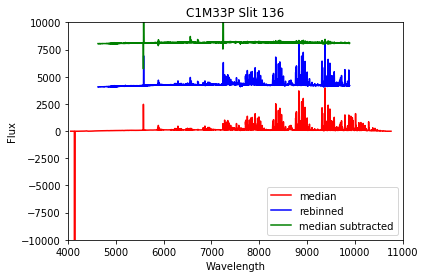

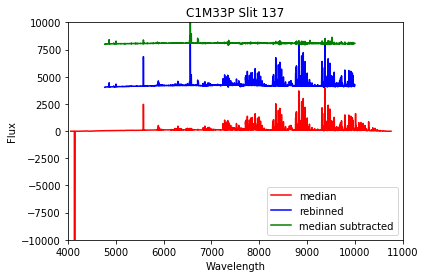

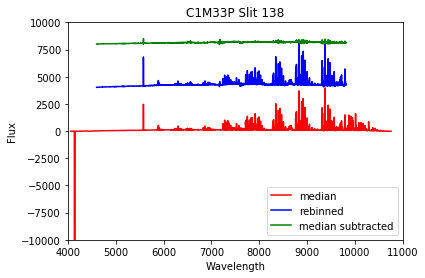

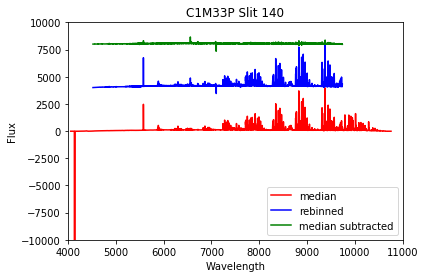

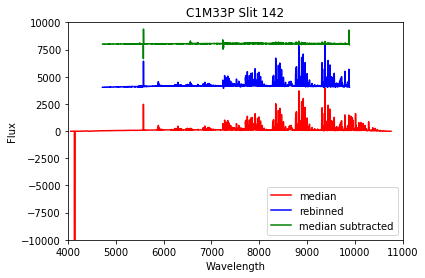

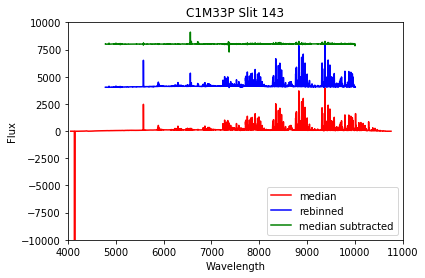

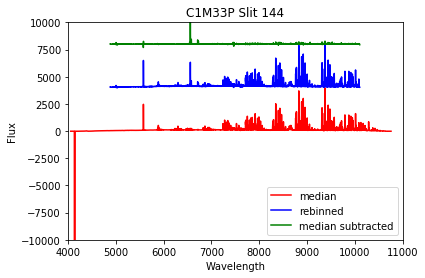

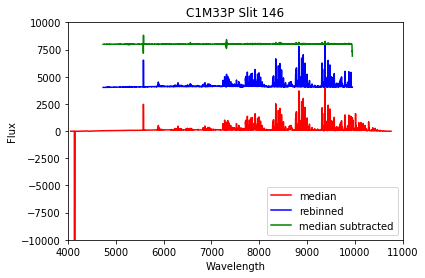

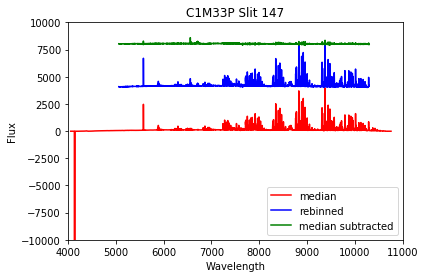

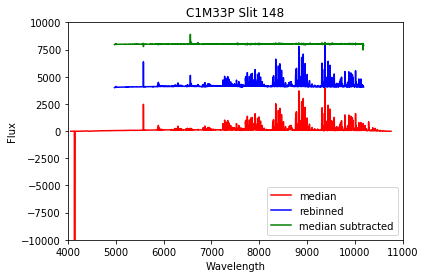

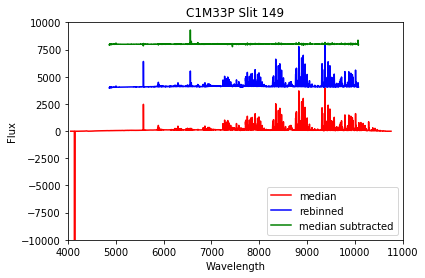

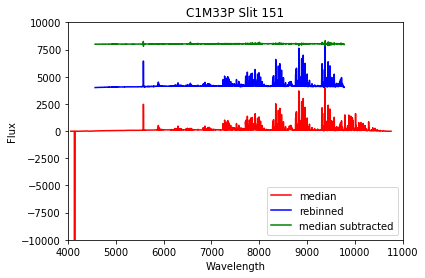

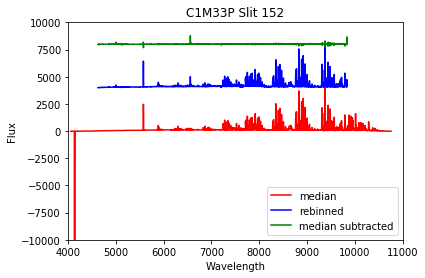

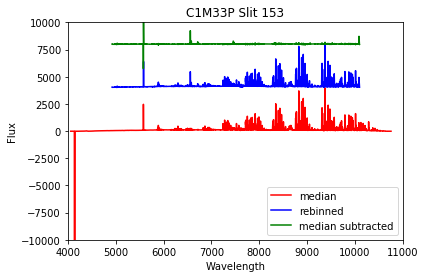

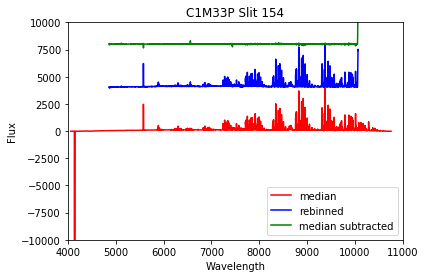

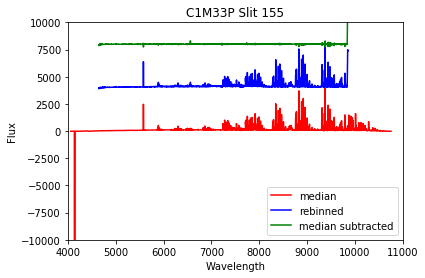

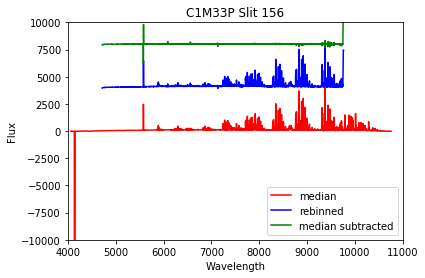

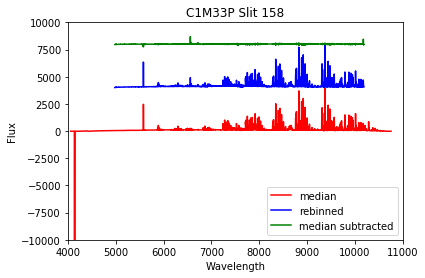

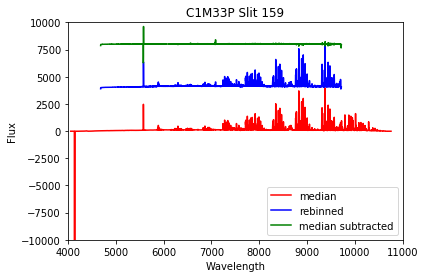

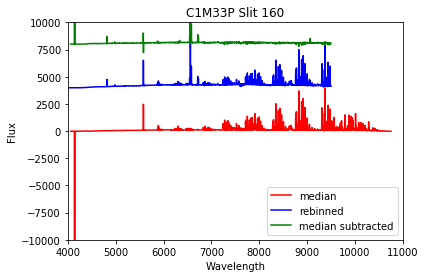

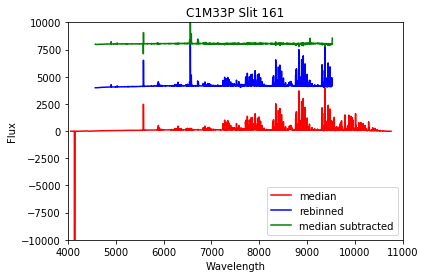

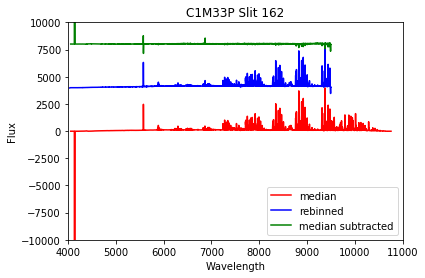

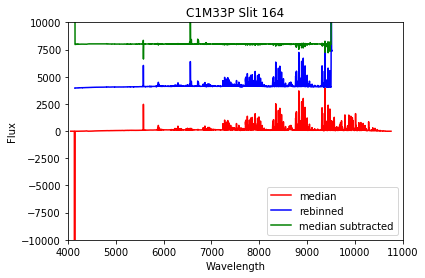

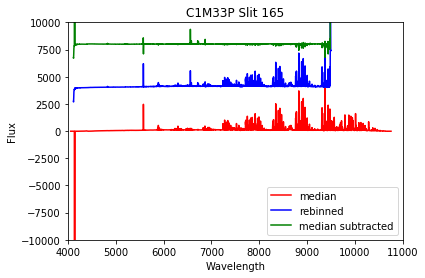

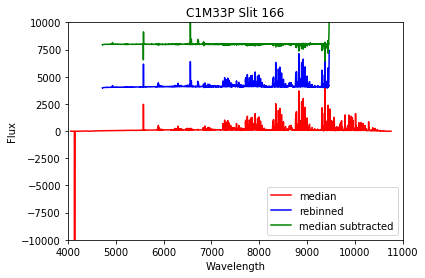

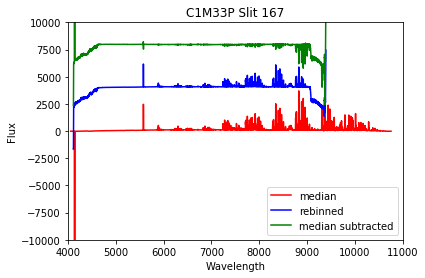

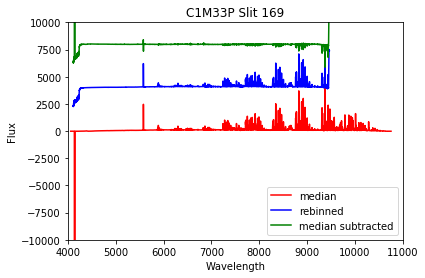

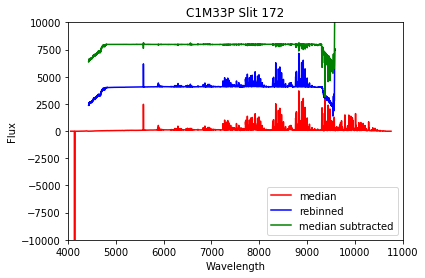

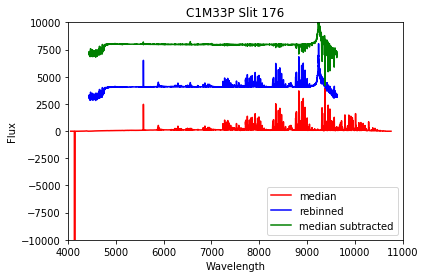

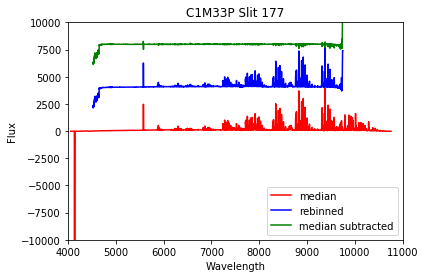

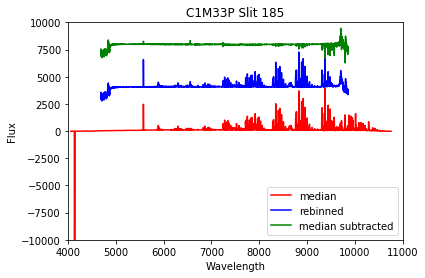

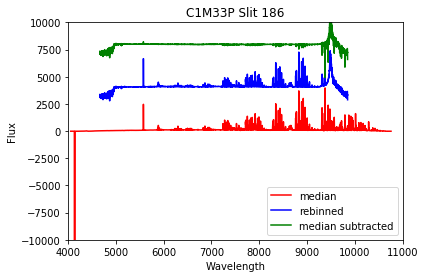

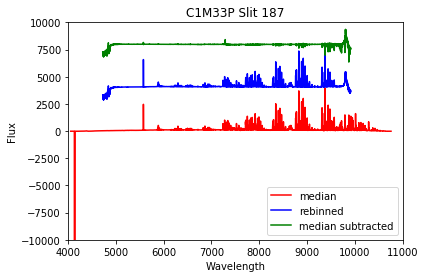

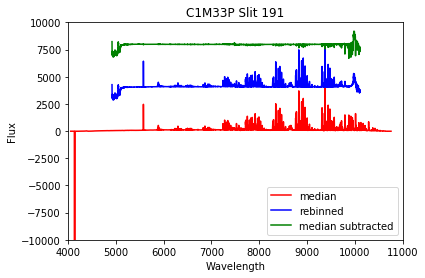

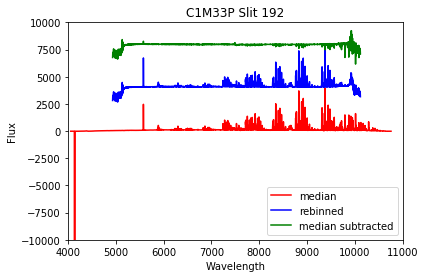

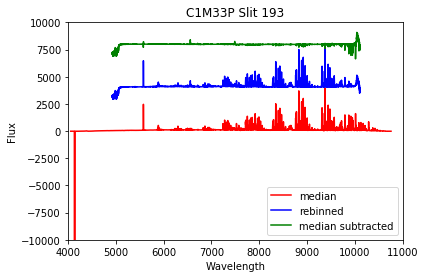

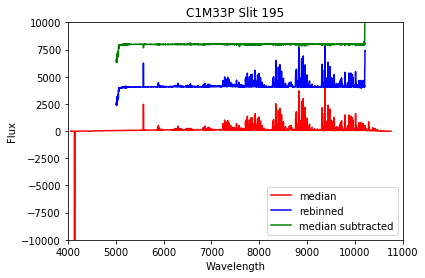

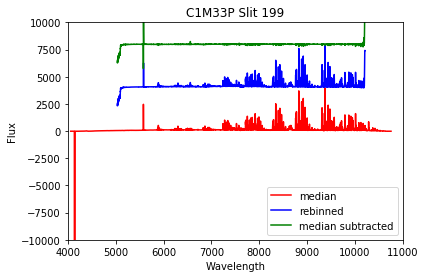

In [33]:
#plot all slits and save it as a png in a folder 
#Need to change the mask name for each mask 
plotting(mask_name, slit_nums, rbflux_fits, median_fits, True)
plotting(mask_name, slit_nums_exclude, rbflux_fits_exclude, median_fits, False)

## Optimization Settings

In [172]:
threshold_median = 150 #define the threshold for median boolean
threshold_sky_sub = 50 #define the threshold for sky subtraction boolean 

multipliers = np.arange(0.1,2.01,0.01) #array of multipliers we want to test
shift_test_values = np.arange(-0.2, 0.21, 0.01) #range of shift values we want to test

## Optimization Process 

### Slits That Are INCLUDED in The Median Calculation

## Scaling

IMPROVEMENT: The indexing issues. Whenever we are analyzing a new part of the graph, we have to keep changing and finding the index. Find a way to make this more efficient!!!

In [28]:
def median_threshold(median, threshold):
    
    median_boolean = []
    
    for value in median:
        
        if np.isfinite(value) == True: #to filter out nan 
            
            if value > threshold:
                median_boolean.append(True)
                
            elif value <= threshold:
                median_boolean.append(False)
            
        else:
            median_boolean.append(False)
            
    median_boolean_array = np.array(median_boolean)
    
    return median_boolean_array

In [29]:
def create_wave_bool(wavelength, min_wave, max_wave):
    
    wavelength_boolean = []
    
    for value in wavelength: 
        
        if (value > min_wave) and (value < max_wave): 
            
            wavelength_boolean.append(True)
            
        else:
            
            wavelength_boolean.append(False)
            
    wavelength_boolean_array = np.array(wavelength_boolean)
            
    return wavelength_boolean_array

In [30]:
def sky_sub_bool(slit_index, rebinned_flux_list, median, threshold):
    new_flux = [] #sky subtracted spectra 
    #slit_index = find_slit_index(slit_nums_exclude,slit_number) #changed slit_nums to slit_nums_exclude
    slit_index = slit_index
    spectrum = rebinned_flux_list[slit_index]

    for i in range(len(spectrum)):
        if np.isfinite(spectrum[i]) == True:
            new_flux.append(spectrum[i] - median[i]) 
        else:
            new_flux.append(spectrum[i])
    
    #rbflux - median is stored as new_flux 
   
    rbflux_boolean =[]
    
    for value in new_flux: #loop through all values in new_flux and determine it's above the threshold
    
        if np.isfinite(value) == True: #to filter out nan 

            if value > threshold:
                    rbflux_boolean.append(False) #if above 150 e/hr, exclude that pixel

            elif value <= threshold:
                    rbflux_boolean.append(True) #if below 150 e/hr, include that pixel
        
        else:
            rbflux_boolean.append(False) #if is a nan value, exclude it 
            
    return np.array(rbflux_boolean)

In [31]:
def rbflux_minus_median(rbflux, median, multipliers):
    
    subtraction_dict = {}
    
    for multiplier in multipliers: 
    
        subtraction_list = (multiplier * np.array(rbflux)) - median
    
        #for n in range(len(rbflux)): 

         #   if np.isfinite(rbflux[n]) == True: #rbflux contains nan 

          #      subtraction = (multiplier * rbflux[n]) - median[n]

           #     subtraction_list.append(subtraction)

            #else:
             #   subtraction_list.append(multiplier * rbflux[n])
    
        subtraction_dict["Multiplier_{}".format(round(multiplier,2))] = subtraction_list
    
    return subtraction_dict

In [32]:
def sorting_rms(multiply_boolean, subtraction_dict, multipliers): #both inputs are same length
    
    rms_dict_sorted = {}
    
    for multiplier in multipliers:
        
        #rms_values = []
        
        subtraction = subtraction_dict["Multiplier_{}".format(round(multiplier,2))]
    
        #for n in range(len(multiply_boolean)):

         #   if multiply_boolean[n] == True: 

          #      rms_values.append(subtraction[n])

           # else:

            #    pass
            
        rms_dict_sorted["Multiplier_{}".format(round(multiplier,2))] = np.array(subtraction)[np.where(multiply_boolean == True)]
                    
    return rms_dict_sorted

In [33]:
def rms_calculation(rms_dict_sorted, multipliers):
    
    try:
        rms_dict = {}

        for multiplier in multipliers:

            values_for_rms_cal = rms_dict_sorted["Multiplier_{}".format(round(multiplier,2))]
            
            rms = statistics.stdev(values_for_rms_cal)

            rms_dict["Multiplier_{}".format(round(multiplier,2))] = rms
        
        return rms_dict
    
    except:
        print("Everything is False. There's no True boolean. Therefore, RMS cannot be calculated.")
        

In [34]:
def plotting_the_rms(slit_number,multipliers, rms_dict, min_wave, max_wave):

    path = "./{0}_Polynomial_Graph/Scaling_vs_RMS/Slit_{1}".format(mask_name,slit_number)
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    try:
        value_list = []

        for multiplier in multipliers: 

            value_list.append(rms_dict["Multiplier_{0}".format(round(multiplier,2))])

        fig = plt.figure(figsize=(8,6))
        fig.patch.set_alpha(1)
        plt.plot(multipliers,value_list)
        plt.xlabel("Scaling")
        plt.ylabel("RMS")
        plt.title("Mask {0}: Slit #{1}\nRMS vs Scaling ({2} A to {3} A)".format(mask_name,slit_number,min_wave,max_wave))
        fig.savefig(path+'/{0}_Slit_{1}_{2}_to_{3}.png'.format(mask_name,slit_number,min_wave,max_wave))
        
        min_val = min(value_list)

        scale = round(multipliers[value_list.index(min_val)],2)

        print("Scaling w/ minimum RMS (Slit #{0}): {1}".format(slit_number,scale) + " ({0} A to {1} A)".format(min_wave,max_wave))
        
        return scale
        
    except:
        print("Because we have no RMS there is no plot.")

## Automating All The Functions Used In Scaling Calculation

In [35]:
def finding_scaling(slit_number,median,threshold_median,threshold_sky_sub,
                    wavelength,min_wave,max_wave,rbflux,multipliers,slit_index,subtraction_dict): 
    
    #all the functions combined together here for convenience!
    
    #boolean array using median and threshold
    median_boolean_array = median_threshold(median, threshold_median)
    
    #boolean array using wavelength
    wavelength_boolean_array = create_wave_bool(wavelength, min_wave, max_wave)
    
    #boolean array using rbflux - median 
    sky_sub_boolean_array = sky_sub_bool(slit_index,rbflux,median,threshold_sky_sub)
    
    #multiply the two boolean arrays
    multiply_boolean = median_boolean_array * wavelength_boolean_array * sky_sub_boolean_array
    
    #calculate all the subtraction using different scaling factor
    #subtraction_dict = rbflux_minus_median(multiply_boolean, rbflux_fits_exclude[index_of_slit], 
                                           #median, multipliers)
    subtraction_dict = subtraction_dict
    
    #sort through all the subtractions and keep only those that are True
    rms_dict_sorted = sorting_rms(multiply_boolean, subtraction_dict, multipliers)
    
    #calculate the RMS associated with each scaling factor 
    rms_dict = rms_calculation(rms_dict_sorted, multipliers)
    
    #plot RMS vs scaling factor
    scaling_value = plotting_the_rms(slit_number,multipliers,rms_dict,min_wave,max_wave)

    return scaling_value

In [36]:
def looping_finding_scale_included_slits(slit_number,index_of_slit,subtraction_dict):

    #wavelength_array =  np.arange(4000,11200,200)
    wavelength_array = np.arange(4000,11500,500)
    #wavelength_array = np.arange(4000, 11350, 350)
    
    scaling_value_dict = {}

    for index in range(len(wavelength_array)):

        if (index + 1) == len(wavelength_array): 
            break

        else:
        
            scaling_value = finding_scaling(slit_number,median,threshold_median,threshold_sky_sub,rbwave_fits[0],wavelength_array[index],
                                            wavelength_array[index+1],rbflux_fits,multipliers,index_of_slit,subtraction_dict)
            
            scaling_value_dict["{0}_to_{1}".format(wavelength_array[index],wavelength_array[index+1])] = scaling_value
            
    return scaling_value_dict


## Polynomial Fits and Weighted Wavelength

In [37]:
def polynomial_first_order(x,poly_const):
    return (x * poly_const[0]) + (poly_const[1])

In [38]:
def polynomial_second_order(x,poly_const): #function that represent the third-order polynomial 
    return (x**2 * poly_const[0]) + (x * poly_const[1]) + (poly_const[2])

In [39]:
def polynomial_third_order(x,poly_const): #function that represent the third-order polynomial 
    return (x**3 * poly_const[0]) + (x**2 * poly_const[1]) + (x * poly_const[2]) + (poly_const[3])

In [40]:
def polynomial_fourth_order(x,poly_const): #function that represent the fourth-order polynomial 
    return (x**4 * poly_const[0]) + (x**3 * poly_const[1]) + (x**2 * poly_const[2]) + (x * poly_const[3]) + (poly_const[4])

In [41]:
def weighted_wave(median,threshold_median,threshold_sky_sub,wavelength,min_wave,max_wave,rbflux,slit_index):
    
    #boolean array using median and threshold
    median_boolean_array = median_threshold(median, threshold_median)
    
    #boolean array using wavelength
    wavelength_boolean_array = create_wave_bool(wavelength, min_wave, max_wave)
    
    #boolean array using rbflux - median 
    sky_sub_boolean_array = sky_sub_bool(slit_index,rbflux,median,threshold_sky_sub)
    
    #multiply the two boolean arrays
    multiply_boolean = median_boolean_array * wavelength_boolean_array * sky_sub_boolean_array
    
    median_values_for_weight = [] #determine the median we want to use as our weight
    median_values_index = []
    
    for n in range(len(multiply_boolean)):
        
        if multiply_boolean[n] == True:
            
            median_values_for_weight.append(median[n])
            median_values_index.append(n)
        
        else:
            
            pass
    
    wavelength_values_for_weight = [] #determine the wavelength we want to use in 
    
    for index in median_values_index:
        
        wavelength_values_for_weight.append(wavelength[index])
    
    #calculating the weighted wavelength
    if len(median_values_for_weight) == 0:
        print("All boolean values are False. Weighted wavelength cannot be calculate! (Wavelength {0} to {1})".format(min_wave,max_wave))
    
    elif len(median_values_for_weight) == len(wavelength_values_for_weight): #make sure they have same length
        
        sigma_med_wave = []
        
        for n in range(len(median_values_for_weight)):
            
            sigma_med_wave.append(median_values_for_weight[n] * wavelength_values_for_weight[n])
        
        weighted_wavelength = sum(np.array(sigma_med_wave)) / sum(np.array(median_values_for_weight))
        
        return weighted_wavelength

In [42]:
def automating_weighted_wave_included_slits(index_of_slit):
    
    #wavelength_array =  np.arange(4000,11200,200)
    wavelength_array = np.arange(4000,11500,500)
    #wavelength_array = np.arange(4000,11350,350)
    
    weighted_wavelength_list = []

    for index in range(len(wavelength_array)):

        if (index + 1) == len(wavelength_array): 
            break

        else:
        
            weighted_wavelength = weighted_wave(median, threshold_median,threshold_sky_sub, rbwave_fits[0],wavelength_array[index],
                                          wavelength_array[index+1],rbflux_fits,index_of_slit)
            
            weighted_wavelength_list.append(weighted_wavelength)

    #weighted_wavelength_list_final = []
    
    #for wavelength in weighted_wavelength_list: #filter out any None values 
        
        #if wavelength != None:
            
            #weighted_wavelength_list_final.append(wavelength)
        
    return weighted_wavelength_list
            

In [43]:
def wavelength_scaling_function(scaling_value_dict, weighted_wavelength): #used to make a plot of optimal scale factor vs wavelength
    
    scaling_values = [] #do not plot any scaling value that has None
    
    wavelength_values = [] #contains all the wavelength we will plots 
    
    for index in range(len(scaling_value_dict.values())): #filtering out the None values
        
        if list(scaling_value_dict.values())[index] != None:
        
            scaling_values.append(list(scaling_value_dict.values())[index])
            
            wavelength_values.append(weighted_wavelength[index])

        else:
            pass
    
    all_wavelength_values = np.arange(4000,11000,0.65) #used to plot every single values between 4000 and 11000 using our polynomial

    #finding the polynomial constant for first order
    poly_const_first_deg = np.polyfit(wavelength_values,scaling_values,1)
    print("First order polynomial: y = {0}x + {1}".format(poly_const_first_deg[0],poly_const_first_deg[1]))
    
    #finding the polynomial constant for second order
    poly_const_second_deg = np.polyfit(wavelength_values,scaling_values,2)
    print("Second order polynomial: y = {0}x^2 + {1}x + {2}".format(poly_const_second_deg[0],
                                                                    poly_const_second_deg[1],poly_const_second_deg[2]))
    
    
    #finding the polynomial constant for third order
    poly_const_third_deg = np.polyfit(wavelength_values,scaling_values,3)
    print("Third order polynomial: y = {0}(x^3) + {1}(x^2) + {2}(x) + {3}".format(poly_const_third_deg[0],
                                                                                  poly_const_third_deg[1],poly_const_third_deg[2],poly_const_third_deg[3]))
    
    #finding the polynomial constant for fourth order
    poly_const_fourth_deg = np.polyfit(wavelength_values,scaling_values,4)
    print("Fourth order polynomial: y = {0}(x^4) + {1}(x^3) + {2}(x^2) + {3}(x) + {4}".format(poly_const_fourth_deg[0],
                                                                                  poly_const_fourth_deg[1],poly_const_fourth_deg[2],poly_const_fourth_deg[3]
                                                                                             ,poly_const_fourth_deg[4]))
    
    
    #calculating the second, third,and fourth order polynomial as a function of wavelength
    poly_first_order = []
    
    poly_second_order = [] #green line
    
    poly_third_order = [] #blue line
    
    poly_fourth_order = [] #orange line
    
    for value in all_wavelength_values:
        poly_first_order.append(polynomial_first_order(value,poly_const_first_deg))
        
        poly_second_order.append(polynomial_second_order(value,poly_const_second_deg))
        
        poly_third_order.append(polynomial_third_order(value,poly_const_third_deg))
        
        poly_fourth_order.append(polynomial_fourth_order(value,poly_const_fourth_deg))
                                                                                            
    
    #plotting the scaling factors, third-order polynomial, fourth-order polynomial as a function of wavelength
    fig,axs = plt.subplots(1)
    axs.set_xlim(3900,11100)
    axs.set_ylim(-0.5,2.5)
    axs.set_title("Optimal Scale Factor vs Wavelength")
    axs.set_xlabel("Wavelength (A)")
    axs.set_ylabel("Optimal Scale Factor")
    axs.plot(all_wavelength_values,poly_first_order,scalex=False,scaley=False,label="First-Order")
    axs.plot(all_wavelength_values,poly_second_order,scalex=False,scaley=False,label="Second-Order",c="green")
    axs.plot(all_wavelength_values,poly_third_order,scalex=False,scaley=False,label="Third-Order")
    axs.plot(all_wavelength_values,poly_fourth_order,scalex=False,scaley=False,label="Fourth-Order")
    axs.scatter(wavelength_values,scaling_values,label="Optimal Scale Factor",c="black")
    axs.legend()
    
    return scaling_values,wavelength_values,poly_const_first_deg


## Improving The Polynomial Fits (Scaling)

In [44]:
def remove_outliers_sigma_clip_scaling(scaling_values_list,weighted_wavelength_list,poly_const_first_deg):
    
    #optimal shifting value - optimal shifting value based on line of best fit
    deviation = []
    
    #determine the vertical difference (deviation) between dots and line of best fit
    for n in range(len(weighted_wavelength_list)):
        deviation.append(np.abs(polynomial_first_order(weighted_wavelength_list[n],poly_const_first_deg) - scaling_values_list[n]))
        
    print("First Deviation: {}".format(deviation))
    print("First Deviation RMS: {}".format(statistics.stdev(deviation)))
    
    
    #BEGIN FIRST ITERATION OF SIGMA-CLIPPING
    
    #variables to store scaling factor and wavelength from first iteration 
    scaling_values_1 = [] #scaling factor that is not an outlier
    wavelength_values_1 = [] #wavelength that is not an outlier
    
    #variables to store outliers 
    outlier_deviation = []
    
    #remove outliers from data
    for n in range(len(deviation)):
        if deviation[n]/statistics.stdev(deviation) < 3:
            scaling_values_1.append(scaling_values_list[n])#keep all non-outlier
            wavelength_values_1.append(weighted_wavelength_list[n])
        #add all outliers to a separate list
        else: 
            outlier_deviation.append(deviation[n])
    
    #if there's no outlier, return inputs 
    if len(outlier_deviation) == 0: 
        return scaling_values_1, wavelength_values_1
        exit()
    
    #if there are outliers, remove the largest one and keep the remaining outliers
    elif len(outlier_deviation) > 1: 
        outlier_deviation.remove(max(outlier_deviation))
        for value in outlier_deviation:
            scaling_values_1.append(scaling_values_list[deviation.index(value)])
            wavelength_values_1.append(weighted_wavelength_list[deviation.index(value)])
     
    #if there is only one values left after the outliers is removed, return scaling values and wavelength
    if len(scaling_values_1) == 0 or len(scaling_values_1) == 1:
        return scaling_values_1,wavelength_values_1
        exit()
    
    
    #PERFORM A NEW FITTING
    
    #calculate new polynomial coefficients
    new_poly_coeff = np.polyfit(wavelength_values_1,scaling_values_1,1)
    
    #CALCULATE NEW DEVIATION AND REMOVE OUTLIERS
    
    new_deviation = []
    
    for n in range(len(wavelength_values_1)):
        new_deviation.append(np.abs(polynomial_first_order(wavelength_values_1[n],new_poly_coeff) - scaling_values_1[n]))
    
    print("Second Deviation: {}".format(new_deviation))
    print("Second Deviation RMS: {}".format(statistics.stdev(new_deviation)))
                             
    #final set of data with outliers removed
    no_outlier_scaling_values_list = []
    no_outlier_wavelength_values_list = []
    
    #to stores outlier deviation for second iteration
    new_outlier_deviation = []
    
    #remove outliers
    for n in range(len(new_deviation)):
        if new_deviation[n]/statistics.stdev(new_deviation) < 3:
            no_outlier_scaling_values_list.append(scaling_values_1[n])#keep all non-outlier
            no_outlier_wavelength_values_list.append(wavelength_values_1[n])
        else:
            new_outlier_deviation.append(new_deviation[n])

    #if there's no outlier, return inputs 
    if len(new_outlier_deviation) == 0 or len(new_outlier_deviation) == 1: 
        return no_outlier_scaling_values_list,no_outlier_wavelength_values_list
        exit()
        
    #if there are outliers, remove the largest one and keep the remaining outliers
    elif len(new_outlier_deviation) > 1: 
        new_outlier_deviation.remove(max(new_outlier_deviation))
        for value in new_outlier_deviation:
            no_outlier_scaling_values_list.append(scaling_values_1[new_deviation.index(value)])
            no_outlier_wavelength_values_list.append(wavelength_values_1[new_deviation.index(value)])
        return no_outlier_scaling_values_list,no_outlier_wavelength_values_list

In [45]:
def new_polynomial_fits(mask_name,slit_num,scaling_values_list,wavelength_values_list):
    
    no_outlier_scaling_values_list = scaling_values_list #scaling values with outliers removed 
    no_outlier_wavelength_values_list = wavelength_values_list #wavelength values with outliers removed
    
    poly_const_first_deg = np.polyfit(no_outlier_wavelength_values_list,no_outlier_scaling_values_list,1) #find the polynomial constants
    print("New First Order Polynomial: y = {0}x + {1}".format(poly_const_first_deg[0],
                                                                    poly_const_first_deg[1]))
    
    all_wavelength_values = np.arange(4000,11000,0.65) #used to plot every single values between 4000 and 11000 using our polynomial
    
    #calculate the new second order polynomial fits
    
    poly_first_order = [] 
    
    for value in all_wavelength_values:
        poly_first_order.append(polynomial_first_order(value,poly_const_first_deg))
        
        
        
    #straighten the ends
        
    #Optimal Scaling Factor of far left wavelength
    left_end_val = polynomial_first_order(min(no_outlier_wavelength_values_list),poly_const_first_deg) 
    
    #Optimal Scaling Factor of far right wavelength
    right_end_val = polynomial_first_order(max(no_outlier_wavelength_values_list),poly_const_first_deg) 
    
    print("Optimal Scale Factor of All Wavelength Before {0} Angstroms: {1}".format(min(no_outlier_wavelength_values_list),left_end_val)) #print them out 
    
    print("Optimal Scale Factor of All Wavelength After {0} Angstroms: {1} ".format(max(no_outlier_wavelength_values_list),right_end_val))
    
    #straighten the LEFT side of the polynomial fit
    for n in range(len(all_wavelength_values)):
        if all_wavelength_values[n] < min(no_outlier_wavelength_values_list):
            poly_first_order[n] = left_end_val
        
    #straighten the RIGHT side of the polynomial fit
    for n in range(len(all_wavelength_values)):
        if all_wavelength_values[n] > max(no_outlier_wavelength_values_list):
            poly_first_order[n] = right_end_val
    
    
    #plot
    fig,axs = plt.subplots(1)
    fig.set_size_inches(8,6)
    fig.patch.set_alpha(1)
    axs.set_xlim(3900,11100)
    axs.set_ylim(-0.5,2.5)
    axs.set_title("Mask {0}: Slit #{1}\nOptimal Scale Factor vs Wavelength".format(mask_name,slit_num))
    axs.set_xlabel("Wavelength (A)")
    axs.set_ylabel("Optimal Scale Factor")
    axs.plot(all_wavelength_values,poly_first_order,scalex=False,scaley=False,label="Second-Order",c="green")
    axs.scatter(wavelength_values_list,scaling_values_list,label="Optimal Scale Factor",c="black")
    fig.savefig("{0}_Polynomial_Graph/Scaling_Fitting/Poly_Graph_{0}_slit_{1}.png".format(mask_name,slit_num))
    
    return no_outlier_wavelength_values_list,left_end_val,right_end_val,poly_const_first_deg

## Scale Original Flux Using Polynomial Fits

In [46]:
def use_new_scaling_factor(flux_include,wave_include,no_outlier_wavelength_values_list,left_end_val,right_end_val,poly_const_first_deg):
    
    flux = flux_include #original flux from FITS files 
    wave = wave_include #original wavelength from FITS files
    
    no_outlier_wavelength_values_list = no_outlier_wavelength_values_list #weighted wavelength with outliers removed 
    
    original_flux_scale = []
    
    for n in range(len(wave_include)): 
        if wave_include[n] < min(no_outlier_wavelength_values_list):
            original_flux_scale.append(flux_include[n] * left_end_val)
        
        elif wave_include[n] > max(no_outlier_wavelength_values_list): 
            original_flux_scale.append(flux_include[n] * right_end_val)
                                      
        else:
            scale_factor = polynomial_first_order(wave_include[n],poly_const_first_deg)
            original_flux_scale.append(flux_include[n] * scale_factor)
            
    return original_flux_scale

## Saving Scaled Flux as FITS Files

In [47]:
def save_new_polynomial_fits_values_scale(no_outlier_scaling_values_list, no_outlier_wavelength_values_list, original_flux_scale, mask_name,slit_number_used):
            
    hdu1 = fits.PrimaryHDU() #primary HDU (empty)
        
    c1 = fits.Column(name='SCALE_VALUES', array=no_outlier_scaling_values_list, format='E')
    c2 = fits.Column(name='WAVELENGHT_VALUES', array=no_outlier_wavelength_values_list, format='E')
    c3 = fits.Column(name='ORIGINAL_FLUX_SCALED', array=original_flux_scale, format='E')

    hdu2 = fits.BinTableHDU.from_columns([c1, c2, c3]) #first extensional HDU (w data)
            
    hdul = fits.HDUList([hdu1, hdu2]) #combine both HDUs into file and write it below
        
    hdul.writeto(path_name + '/{0}_Rebinned/{0}_Scale_Values/Scale_Values_Polynomial_Fits_{0}_{1}.fits.gz'.format(mask_name,slit_number_used))

## Shifting 

In [48]:
def shifting_wavelength(waves, shifting_value):
    
    waves_shifted = []
    
    for i in range(len(waves)):
        waves_shifted.append(waves[i] + shifting_value)
    
    return waves_shifted

In [49]:
def looping_shifting_wavelength(original_wavelength,test_values,index_of_slit):
    
    wave_shifted_dict = {}
    
    for value in test_values: 
        wave_shifted = shifting_wavelength(original_wavelength[index_of_slit],value)
        wave_shifted_dict["Shifted_{}".format(round(value,2))] = wave_shifted
    
    return wave_shifted_dict

In [50]:
def rebin_wave_shifted(wave_shifted_dict,flux,ivar,test_values,index_of_slit):
    
    rbflux_shifted_dict = {}
    
    for value in test_values:
        
        rbflux_shifted,rbwave_shifted,rbivar_shifted = rebin([flux[index_of_slit]], 
                                                             [wave_shifted_dict["Shifted_{}".format(round(value,2))]], 
                                                             [ivar[index_of_slit]], 600)
        
        
        rbflux_shifted_dict["Shifted_{}".format(round(value,2))] = rbflux_shifted
    
    return rbflux_shifted_dict

In [51]:
#def sorting_shifted_rms(multiply_boolean,rbflux_shifted_dict,shift_test_values):
    #rms_dict_sorted = {}
    
    #for test_value in shift_test_values:
        
     #   rbflux_shifted = rbflux_shifted_dict["Shifted_{}".format(round(test_value,2))]

      #  rms_dict_sorted["Shifted_{}".format(round(test_value,2))] = rbflux_shifted[0][np.where(multiply_boolean == True)]
                    
    #return rms_dict_sorted


In [52]:
def sorting_shifted_rms(multiply_boolean,rbflux_shifted_dict,shift_test_values):
    rms_dict_sorted = {}
    
    for test_value in shift_test_values:
        
        #rms_values = []
        
        rbflux_shifted = rbflux_shifted_dict["Shifted_{}".format(round(test_value,2))]
        
        #for n in range(len(multiply_boolean)):

            #if multiply_boolean[n] == True: 

              #  rms_values.append(rbflux_shifted[0][n])

            #else:

               # pass
        #   
        rms_values = np.array(rbflux_shifted[0])[np.where(multiply_boolean == True)]
        
        rms_dict_sorted["Shifted_{}".format(round(test_value,2))] = rms_values
                    
    return rms_dict_sorted

In [53]:
def rbflux_shifted_minus_median(multiply_boolean,scaling_value_dict,rms_dict_sorted,shift_test_values,min_wave,max_wave):
    if scaling_value_dict["{0}_to_{1}".format(min_wave,max_wave)] != None:
        optimal_scaling_factor = scaling_value_dict["{0}_to_{1}".format(min_wave,max_wave)]
    else:
        optimal_scaling_factor = 1
        
    subtraction_dict_shifted = {}
    
    median_cut = np.array(median)[np.where(multiply_boolean == True)]
    
    for test_value in shift_test_values:
        
        rms_values_sorted = rms_dict_sorted["Shifted_{0}".format(round(test_value,2))]
        
        #
        subtraction_list = (np.array(rms_values_sorted)*optimal_scaling_factor) - median_cut
        
       # for n in range(len(rms_values_sorted)):
                
                #subtraction = (rms_values_sorted[n]*optimal_scaling_factor) - median_cut[n]
                #subtraction = rbflux_shifted[n]- median[n]
                
                #subtraction_list.append(subtraction)
                
                
        subtraction_dict_shifted["Shifted_{0}".format(round(test_value,2))] = subtraction_list 
    
    return subtraction_dict_shifted

In [54]:
def rms_calculation_shift(rms_dict_sorted_shift, shift_test_values):
    
    rms_dict_shift = {}

    for test_value in shift_test_values:

        values_for_rms_cal = rms_dict_sorted_shift["Shifted_{}".format(round(test_value,2))]

        rms = statistics.stdev(values_for_rms_cal)

        rms_dict_shift["Shifted_{}".format(round(test_value,2))] = rms
        
    return rms_dict_shift
    
    
        #print("Everything is False. There's no True boolean. Therefore, RMS cannot be calculated.")

In [55]:
def plotting_the_shift_rms(slit_number,shift_test_values, rms_dict_shift, min_wave, max_wave):
    
    value_list = []
    path = "./{0}_Polynomial_Graph/Scaling_vs_RMS(Shifting)/Slit_{1}".format(mask_name,slit_number)
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    for test_value in shift_test_values: 

        value_list.append(rms_dict_shift["Shifted_{0}".format(round(test_value,2))])

    fig = plt.figure(figsize=(8,6))
    fig.patch.set_alpha(1)
    plt.plot(shift_test_values,value_list)
    plt.xlabel("Scaling")
    plt.ylabel("RMS")
    plt.title("Mask {0}: Slit #{1}\nRMS vs Scaling (Shifting Process) ({2} A to {3} A)".format(mask_name,slit_number,min_wave,max_wave))
    fig.savefig(path+'/{0}_Slit_{1}_{2}_to_{3}.png'.format(mask_name,slit_number,min_wave,max_wave))
        
    min_val = min(value_list)

    shifting_value = round(shift_test_values[value_list.index(min_val)],2)

    print("Shifting w/ minimum RMS (Slit #{0}): {1}".format(slit_number,shifting_value) + " ({0} A to {1} A)".format(min_wave,max_wave))

    return shifting_value
        
    
        #print("Because we have no RMS there is no plot.")
        
    

In [56]:
def plotting_with_shifting(median,rbflux,multiplier,min_ylim,max_ylim,min_xlim,max_xlim):
    new_flux = [] #sky subtracted spectra w/ scaling
    new_flux_no_scaling = [] #sky subtracted spectra w/o scaling
    rbflux_with_scaling = []
    spectrum = rbflux
    multiplier = multiplier 

    #multiplying the rbflux by scaling factor 
    for i in range(len(spectrum)):
        if np.isfinite(spectrum[i]) == True:
            new_flux.append((spectrum[i] * multiplier) - median[i]) 
            rbflux_with_scaling.append((spectrum[i] * multiplier))
        else:
            new_flux.append(spectrum[i])
            rbflux_with_scaling.append(spectrum[i])

     #no scaling factor
    for i in range(len(spectrum)):
        if np.isfinite(spectrum[i]) == True:
            new_flux_no_scaling.append((spectrum[i]) - median[i]) 
        else:
            new_flux_no_scaling.append(spectrum[i])
        
    #plotting 
    fig,axs = plt.subplots(1)
    plt.ylim(min_ylim,max_ylim) #could try getting a smaller y limit and getting rid of legend
    plt.xlim(min_xlim,max_xlim)
    plt.plot(new_wave_600, median, c="r", scalex=False, scaley=False, label = "median")
    plt.plot(new_wave_600, rbflux_with_scaling, c="b", scalex=False, scaley=False, label = "rebinned w/ scaling")
    plt.plot(new_wave_600, np.array(new_flux_no_scaling), c="purple", scalex=False, scaley=False, label = "Subtracted w/o scaling")
    plt.plot(new_wave_600, np.array(new_flux), c="g", scalex=False, scaley=False,label = "subtracted")
    plt.xlabel("Wavelength (A)")
    plt.ylabel("Flux (Electron/Hour)")
    plt.title("Slit #115 Scaled + Shifted" + "/Multiplier: {}".format(multiplier) + "/From {0} to {1}".format(min_xlim,max_xlim))

## Automating All The Functions Used in The Shifting Process

In [57]:
def finding_shifting(slit_number,flux,wave,ivar,scaling_value_dict,median,threshold_median,wavelength,
                     slit_index,rbflux_list,threshold_sky_sub):
    
    #define all values we want to test
    shift_test_values = np.arange(-0.2,0.21,0.01)
    
    #shift original wavelength by test values
    #store everything as a dictionary. Format: "Shifted_(test_value):[shifted wavelength]"
    wave_shifted_dict = looping_shifting_wavelength(wave,shift_test_values,slit_index) 
    
    #rebin using shifted wavelength 
    #store rebinned flux as a dictionary. Format: " Shifted_(test_value):[rebinned flux]"
    rbflux_shifted_dict = rebin_wave_shifted(wave_shifted_dict,flux,ivar,shift_test_values,slit_index)
    
    #500 A segments 
    wavelength_array = np.arange(4000,11500,500)
    
    shifting_value_dict = {}
    
    #for loop to find the multiply_boolean and median-subtracted spectrum
    for n in range(len(wavelength_array)):

        if (n + 1) == len(wavelength_array): 
            break

        else:
            #boolean array using median and threshold
            median_boolean_array = median_threshold(median,threshold_median)
    
            #boolean array using wavelength
            wavelength_boolean_array = create_wave_bool(wavelength, wavelength_array[n], wavelength_array[n+1])

            #boolean array using rbflux - median 
            sky_sub_boolean_array = sky_sub_bool(slit_index,rbflux_list,median,threshold_sky_sub)

            #multiply the two boolean arrays
            multiply_boolean = median_boolean_array * wavelength_boolean_array * sky_sub_boolean_array

            #values that will be used to calculate the rms 
            values_for_shift_rms = sorting_shifted_rms(multiply_boolean,rbflux_shifted_dict,shift_test_values)
            
            #use the rebinned flux, the optimal scaling factor, and median to calculate the median-subtracted spectrum
            #scaling_value_dict contain the optimal scaling factor of each 500 segment
            subtraction_dict_shifted = rbflux_shifted_minus_median(multiply_boolean,scaling_value_dict,values_for_shift_rms,
                                                                   shift_test_values,wavelength_array[n],wavelength_array[n+1])
            
            
            if len(subtraction_dict_shifted["Shifted_0.2"]) == 0 or len(subtraction_dict_shifted["Shifted_0.2"]) == 1:
                shifting_value_dict["{0}_to_{1}".format(wavelength_array[n],wavelength_array[n+1])] = None
                print("Boolean are all False. No values can be use to calculate the RMS. From {0} to {1}".format(wavelength_array[n],wavelength_array[n+1]))
                
            else: 
            
                #rms values
                rms_dict_shift = rms_calculation_shift(subtraction_dict_shifted,shift_test_values)

                #rms values that will be used 
                shifting_value = plotting_the_shift_rms(slit_number,shift_test_values,rms_dict_shift,wavelength_array[n],wavelength_array[n+1])

                shifting_value_dict["{0}_to_{1}".format(wavelength_array[n],wavelength_array[n+1])] = shifting_value
            
    return shifting_value_dict,rbflux_shifted_dict

## Saving Scale and Shift Factor and Reading It Back

In [58]:
def saving_scaling_and_shifting_factor(mask_name,slit_number_used,scaling_value_dict,shifting_value_dict):
    
    hdu1 = fits.PrimaryHDU()
    
    c1 = fits.Column(name="SCALING_FACTOR", array=list(scaling_value_dict.values()), format='E')
    c2 = fits.Column(name="SHIFTING_FACTOR", array=list(shifting_value_dict.values()), format='E')

    hdu2 = fits.BinTableHDU.from_columns([c1,c2])
    
    hdul = fits.HDUList([hdu1,hdu2])
    
    hdul.writeto(path_name + '/{0}_Rebinned/{0}_Scaling_and_Shifting_Factor/Scaling_and_Shifting_Factor_{0}_{1}.fits.gz'.format(mask_name,slit_number_used))

## Saving Rebinned Flux Calculated Using Shifted Wavelength

In [59]:
#saving rbflux_shifted_dict as a nyp files, take a bit of space, need to reduce it.
#get only the rbflux that we will need 
def sorting_needed_shift_factor(shifting_value_dict,rbflux_shifted_dict):
    
    original_shift_factor_list = list(shifting_value_dict.values())
    
    #remove all duplicate and all None 
    remove_duplicate_and_none = list(set(original_shift_factor_list))
    
    #selects only values that are optimal shift factor
    sorted_rbflux_shifted_dict = {}
    
    for value in remove_duplicate_and_none:
        if value == None:
            remove_duplicate_and_none.remove(value)
            
    for value in remove_duplicate_and_none:
        sorted_rbflux_shifted_dict["Shifted_{0}".format(value)] = rbflux_shifted_dict["Shifted_{0}".format(value)]
            
    return(sorted_rbflux_shifted_dict)


In [60]:
#note sure how to save dictionary as FITS file, therefore, use npy file
def saving_rbflux_shifted(mask_name,slit_number_used,sorted_rbflux_shifted_dict):
    
    #saving the dictionary as a npy file
    np.save("./{0}_Rebinned/{0}_Rebinned_Flux_Shifted_Wave/rbflux_shifted_dict_{0}_{1}.npy".format(mask_name,slit_number_used),sorted_rbflux_shifted_dict)

## Polynomial Fit for Shifting

In [61]:
def wavelength_shifting_function(shifting_value_dict, weighted_wavelength): #used to make a plot of optimal shifting factor vs wavelength
    
    shifting_values = [] #do not plot any shifting value that has None
    
    wavelength_values = [] #contains all the wavelength we will plots 
    
    for index in range(len(shifting_value_dict.values())): #filtering out the None values
        
        if list(shifting_value_dict.values())[index] != None:
        
            shifting_values.append(list(shifting_value_dict.values())[index])
            
            wavelength_values.append(weighted_wavelength[index])

        else:
            pass
    
    all_wavelength_values = np.arange(4000,11000,0.65) #used to plot every single values between 4000 and 11000 using our polynomial

    #finding the polynomial constant for second order
    poly_const_second_deg = np.polyfit(wavelength_values,shifting_values,2)
    print("Second order polynomial: y = {0}x^2 + {1}x + {2}".format(poly_const_second_deg[0],
                                                                    poly_const_second_deg[1],poly_const_second_deg[2]))
    
    #finding the polynomial constant for third order
    poly_const_third_deg = np.polyfit(wavelength_values,shifting_values,3)
    print("Third order polynomial: y = {0}(x^3) + {1}(x^2) + {2}(x) + {3}".format(poly_const_third_deg[0],
                                                                                  poly_const_third_deg[1],poly_const_third_deg[2],poly_const_third_deg[3]))
    
    #finding the polynomial constant for fourth order
    poly_const_fourth_deg = np.polyfit(wavelength_values,shifting_values,4)
    print("Fourth order polynomial: y = {0}(x^4) + {1}(x^3) + {2}(x^2) + {3}(x) + {4}".format(poly_const_fourth_deg[0],
                                                                                  poly_const_fourth_deg[1],poly_const_fourth_deg[2],poly_const_fourth_deg[3]
                                                                                             ,poly_const_fourth_deg[4]))
    
    
    #calculating the third and fourth order polynomial as a function of wavelength
    poly_second_order = []
    
    poly_third_order = []
    
    poly_fourth_order = []
    
    for value in all_wavelength_values:
        poly_second_order.append(polynomial_second_order(value,poly_const_second_deg))
        
        poly_third_order.append(polynomial_third_order(value,poly_const_third_deg))
        
        poly_fourth_order.append(polynomial_fourth_order(value,poly_const_fourth_deg))
                                                                                            
    #plotting the optimal shifting factors, third-order polynomial, fourth-order polynomial as a function of wavelength
    fig,axs = plt.subplots(1)
    axs.set_xlim(3900,11100)
    axs.set_ylim(-0.25,0.25)
    axs.set_title("Optimal Shifting Factor vs Wavelength")
    axs.set_xlabel("Wavelength (A)")
    axs.set_ylabel("Optimal Shifting Factor")
    axs.plot(all_wavelength_values,poly_second_order,scalex=False,scaley=False,label="Second-Order",c="green")
    axs.plot(all_wavelength_values,poly_third_order,scalex=False,scaley=False,label="Third-Order",c="blue")
    axs.plot(all_wavelength_values,poly_fourth_order,scalex=False,scaley=False,label="Fourth-Order",c="orange")
    axs.scatter(wavelength_values, shifting_values,label="Optimal Shifting Factor",c="black")
    axs.legend()
    
    return shifting_values,wavelength_values,poly_const_second_deg

## Improving The Polymial Fits (Shifting)

In [62]:
def remove_outliers_sigma_clip_shifting(shifting_values_list,weighted_wavelength_list,poly_const_second_deg):
    
    #optimal shifting value - optimal shifting value based on line of best fit
    deviation = [] 
    
    #determine the vertical difference (deviation) between dots and line of best fit
    for n in range(len(weighted_wavelength_list)):
        deviation.append(np.abs(polynomial_second_order(weighted_wavelength_list[n],poly_const_second_deg) - shifting_values_list[n]))
    
    print("First Deviation: {}".format(deviation))
    print("First Deviation RMS: {}".format(statistics.stdev(deviation)))
    
    #BEGIN FIRST ITERATION
    
    #first iteration 
    shifting_values_1 = []
    wavelength_values_1 = []
    
    #to store outlier
    outlier_deviation = []
    
    #remove outliers from data
    for n in range(len(deviation)):
        if deviation[n]/statistics.stdev(deviation) < 3.5:
            shifting_values_1.append(shifting_values_list[n])#keep all non-outlier
            wavelength_values_1.append(weighted_wavelength_list[n])
        #add all outliers to a separate list
        else: 
            outlier_deviation.append(deviation[n])
    
    #if there's no outlier, return inputs 
    if len(outlier_deviation) == 0: 
        return shifting_values_1, wavelength_values_1
        exit()
    
    #if there are outliers, remove the largest one and keep the remaining outliers
    elif len(outlier_deviation) > 1: 
        outlier_deviation.remove(max(outlier_deviation))
        for value in outlier_deviation:
            shifting_values_1.append(shifting_values_list[deviation.index(value)])
            wavelength_values_1.append(weighted_wavelength_list[deviation.index(value)])
     
    #if there is only one values left after the outliers is removed, return shifting values and wavelength
    if len(shifting_values_1) == 0 or len(shifting_values_1) == 1:
        return shifting_values_1,wavelength_values_1
        exit()
    
    #PERFORM A NEW FITTING
    
    new_poly_coeff = np.polyfit(wavelength_values_1,shifting_values_1,2)
    
    
    #CALCULATE NEW DEVIATION AND REMOVE OUTLIERS
    
    new_deviation = []
    
    for n in range(len(wavelength_values_1)):
        new_deviation.append(np.abs(polynomial_second_order(wavelength_values_1[n],new_poly_coeff) - shifting_values_1[n]))
    
    print("Second Deviation: {}".format(new_deviation))
    print("Second Deviation RMS: {}".format(statistics.stdev(new_deviation)))
                             
    #final set of data with outliers removed
    no_outlier_shifting_values_list = []
    no_outlier_wavelength_values_list = []
    
    #to stores outliers
    new_outlier_deviation = []
    
    #remove outliers
    for n in range(len(new_deviation)):
        if new_deviation[n]/statistics.stdev(new_deviation) < 3.5:
            no_outlier_shifting_values_list.append(shifting_values_1[n])#keep all non-outlier
            no_outlier_wavelength_values_list.append(wavelength_values_1[n])
        else:
            new_outlier_deviation.append(new_deviation[n])
    
    #if there's no outlier or just one outlier, return final list of scale factor and wavelength 
    if len(new_outlier_deviation) == 0 or len(new_outlier_deviation) == 1:
        return no_outlier_shifting_values_list, no_outlier_wavelength_values_list
        exit()
    
    #if there are outliers, remove the largest one and keep the remaining outliers
    elif len(new_outlier_deviation) > 1: 
        new_outlier_deviation.remove(max(new_outlier_deviation))
        for value in new_outlier_deviation:
            no_outlier_shifting_values_list.append(shifting_values_1[new_deviation.index(value)])
            no_outlier_wavelength_values_list.append(wavelength_values_1[new_deviation.index(value)])
        return no_outlier_shifting_values_list,no_outlier_wavelength_values_list
    

In [63]:
def new_polynomial_fits_shifting(mask_name,slit_num,shifting_values_list,wavelength_values_list):
    
    no_outlier_shifting_values_list = shifting_values_list #scaling values with outliers removed 
    no_outlier_wavelength_values_list = wavelength_values_list #wavelength values with outliers removed
    
    poly_const_second_deg = np.polyfit(no_outlier_wavelength_values_list,no_outlier_shifting_values_list,2) #find the polynomial constants
    print("New Second Order Polynomial: y = {0}x^2 + {1}x + {2}".format(poly_const_second_deg[0],
                                                                    poly_const_second_deg[1],poly_const_second_deg[2]))
    
    all_wavelength_values = np.arange(4000,11000,0.65) #used to plot every single values between 4000 and 11000 using our polynomial
    
    #calculate the new second order polynomial fits
    
    poly_second_order = [] 
    
    for value in all_wavelength_values:
        poly_second_order.append(polynomial_second_order(value,poly_const_second_deg))
        
    #straighten the ends
        
    #Optimal Scaling Factor of far left wavelength
    left_end_val = polynomial_second_order(min(no_outlier_wavelength_values_list),poly_const_second_deg) 
    
    #Optimal Scaling Factor of far right wavelength
    right_end_val = polynomial_second_order(max(no_outlier_wavelength_values_list),poly_const_second_deg) 
    
    print("Optimal Shift Factor of All Wavelength Before {0} Angstroms: {1}".format(min(no_outlier_wavelength_values_list),left_end_val)) #print them out 
    
    print("Optimal Shift Factor of All Wavelength After {0} Angstroms: {1} ".format(max(no_outlier_wavelength_values_list),right_end_val))
    
    #straighten the LEFT side of the polynomial fit
    for n in range(len(all_wavelength_values)):
        if all_wavelength_values[n] < min(no_outlier_wavelength_values_list):
            poly_second_order[n] = left_end_val
        
    #straighten the RIGHT side of the polynomial fit
    for n in range(len(all_wavelength_values)):
        if all_wavelength_values[n] > max(no_outlier_wavelength_values_list):
            poly_second_order[n] = right_end_val
        
    #plot
    fig,axs = plt.subplots(1)
    fig.set_size_inches(8,6)
    fig.patch.set_alpha(1)
    axs.set_xlim(3900,11100)
    axs.set_ylim(-0.25,0.25)
    axs.set_title("Mask {0}: Slit #{1}\nOptimal Shift Factor vs Wavelength".format(mask_name,slit_num))
    axs.set_xlabel("Wavelength (A)")
    axs.set_ylabel("Optimal Shift Factor")
    axs.plot(all_wavelength_values,poly_second_order,scalex=False,scaley=False,label="Second-Order",c="green")
    axs.scatter(wavelength_values_list,shifting_values_list,label="Optimal Shift Factor",c="black")
    fig.savefig("{0}_Polynomial_Graph/Shifting_Fitting/Poly_Graph_{0}_slit_{1}.png".format(mask_name,slit_num))
    
    return no_outlier_wavelength_values_list,left_end_val,right_end_val,poly_const_second_deg

## Shift Original Wavelength Using Polynomial Fits

In [64]:
def use_new_shifting_factor(wave,no_outlier_wavelength_values_list,left_end_val,right_end_val,poly_const_second_deg):
     
    wave = wave #original wavelength from FITS files
    
    no_outlier_wavelength_values_list = no_outlier_wavelength_values_list #weighted wavelength with outliers removed 
    
    original_wavelength_shift = []
    
    for n in range(len(wave)): 
        if wave[n] < min(no_outlier_wavelength_values_list):
            original_wavelength_shift.append(wave[n] + left_end_val)
        
        elif wave[n] > max(no_outlier_wavelength_values_list): 
            original_wavelength_shift.append(wave[n] + right_end_val)
                                      
        else:
            shift_factor = polynomial_second_order(wave[n],poly_const_second_deg)
            original_wavelength_shift.append(wave[n] + shift_factor)
            
    return original_wavelength_shift

## Saving Shifted Wavelength as FITS Files

In [65]:
def save_new_polynomial_fits_values_shift(no_outlier_scaling_values_list, no_outlier_wavelength_values_list, original_wavelength_shift,mask_name,slit_number_used):
            
    hdu1 = fits.PrimaryHDU() #primary HDU (empty)
        
    c1 = fits.Column(name='SHIFT_VALUES', array=no_outlier_scaling_values_list, format='E')
    c2 = fits.Column(name='WAVELENGHT_VALUES', array=no_outlier_wavelength_values_list, format='E')
    c3 = fits.Column(name='ORIGINAL_WAVELENGTH_SHIFTED', array=original_wavelength_shift, format='E')

    hdu2 = fits.BinTableHDU.from_columns([c1, c2, c3]) #first extensional HDU (w data)
            
    hdul = fits.HDUList([hdu1, hdu2]) #combine both HDUs into file and write it below
        
    hdul.writeto(path_name + '/{0}_Rebinned/{0}_Shift_Values/Shift_Values_Polynomial_Fits_{0}_{1}.fits.gz'.format(mask_name,slit_number_used))


## Saving Polynomial Coefficients

In [66]:
def save_polynomial_coeff(mask_name,slit_number_used,poly_const_first_deg_scal,poly_const_second_deg_shift,left_end_val,right_end_val,no_outlier_wavelength_values_list):
    
    hdu1 = fits.PrimaryHDU() #primary HDU (empty)
        
    c1 = fits.Column(name='POLYNOMIAL_COEFFICIENTS_SCALING', array=poly_const_first_deg_scal, format='E')
    c2 = fits.Column(name='POLYNOMIAL_COEFFICIENTS_SHIFTING', array=poly_const_second_deg_shift, format='E')
    c3 = fits.Column(name='END_VALUES', array=[left_end_val,right_end_val], format='E')
    c4 = fits.Column(name='NO_OUTLIER_WEIGHTED_WAVE',array=no_outlier_wavelength_values_list,format='E')
    
    hdu2 = fits.BinTableHDU.from_columns([c1,c2,c3,c4]) #first extensional HDU (w data)
            
    hdul = fits.HDUList([hdu1, hdu2]) #combine both HDUs into file and write it below
        
    hdul.writeto(path_name + '/{0}_Rebinned/{0}_Polynomial_Coefficients/Poly_Coeff_{0}_{1}.fits.gz'.format(mask_name,slit_number_used))
    

## Automate Optimization of Included Slits

In [67]:
def looping_through_all_function_included_slits(slit_numbers_to_automate):
    for slit_number in slit_numbers_to_automate:
        
        slit_number_used = slit_number
        print('\nOptimizing slit #{0} (Included) from mask {1}.'.format(slit_number_used,mask_name))

        index_of_slit = slit_nums.index(slit_number_used) #index of slit that are excluded (Contain ISM Em Line)
        #slit_nums_exclude will need to be changed for slits that are included

        #Determine the Optimal Scale Factor 
        print('Finding the Optimal Scale Factor...')
        subtraction_dict = rbflux_minus_median(rbflux_fits[index_of_slit], median, multipliers)

        scaling_value_dict = looping_finding_scale_included_slits(slit_number_used,index_of_slit,subtraction_dict)

        #Determine the weighted wavelength 
        weighted_wavelength_list = automating_weighted_wave_included_slits(index_of_slit) #there is some None values. Let's filter it out! 
        print("List of All Weighted Wavelength: {0}".format(weighted_wavelength_list))

        try:
            #Original Polynomial Fits for Scaling
            scaling_values_list,wavelength_values_scal,poly_const_first_deg_scaling = wavelength_scaling_function(scaling_value_dict,weighted_wavelength_list)

            #Improving Original Polynomial Fits for Scaling
            #Remove Outliers Using Sigma Clipping
            no_outlier_scaling_values_list, no_outlier_wavelength_values_list_scal = remove_outliers_sigma_clip_scaling(scaling_values_list,wavelength_values_scal,poly_const_first_deg_scaling)

            #New Polynomial Fits for Scaling
            no_outlier_wavelength_values_list_scal,left_end_val_scal,right_end_val_scal,poly_const_first_deg_scal = new_polynomial_fits(mask_name,slit_number_used,no_outlier_scaling_values_list,no_outlier_wavelength_values_list_scal)

            #Use New Poly Fits to Scale Original Flux
            original_flux_scale = use_new_scaling_factor(flux[index_of_slit],wave[index_of_slit],
                               no_outlier_wavelength_values_list_scal,left_end_val_scal,
                               right_end_val_scal,poly_const_first_deg_scal)

        except TypeError:
            poly_const_first_deg_scal = [0,1] #straight horizontal line, no scaling
            no_outlier_scaling_values_list = list(scaling_value_dict.values())
            no_outlier_wavelength_values_list_scal = weighted_wavelength_list
            original_flux_scale = flux[index_of_slit]
            
        
        #Saving Scaled Original Flux as FITS Files
        save_new_polynomial_fits_values_scale(no_outlier_scaling_values_list, no_outlier_wavelength_values_list_scal, original_flux_scale,mask_name,slit_number_used)

        
        #Determine the Optimal Shift Factor 
        print('Finding the Optimal Shift Factor...')
        shifting_value_dict,rbflux_shifted_dict = finding_shifting(slit_number_used,flux,wave,ivar,scaling_value_dict,median,threshold_median,rbwave_fits[0],index_of_slit,rbflux_fits,threshold_sky_sub)
        
        #Saving the Scale Factor and Shift Factor
        saving_scaling_and_shifting_factor(mask_name,slit_number_used,scaling_value_dict,shifting_value_dict)
        
        #Sort through rbflux_shifted_dict and remove all key-value we don't need (reduce size of saved file)
        sorted_rbflux_shifted_dict = sorting_needed_shift_factor(shifting_value_dict,rbflux_shifted_dict)
        
        #Saving the rebinned flux calculated using the shifted wavelength
        saving_rbflux_shifted(mask_name,slit_number_used,sorted_rbflux_shifted_dict)

        try:
            #Original Polynomial Fits for Shifting
            shifting_values_list,wavelength_values_shift,poly_const_second_deg_shifting = wavelength_shifting_function(shifting_value_dict,weighted_wavelength_list)

            #Improving Original Polynomial Fits for Shifting
            #Remove Outliers 
            no_outlier_shifting_values_list, no_outlier_wavelength_values_list_shift = remove_outliers_sigma_clip_shifting(shifting_values_list,wavelength_values_shift,poly_const_second_deg_shifting)

            #New Polynomial Fits for Shifting
            no_outlier_wavelength_values_list_shift,left_end_val_shift,right_end_val_shift,poly_const_second_deg_shift = new_polynomial_fits_shifting(mask_name,slit_number_used,no_outlier_shifting_values_list,no_outlier_wavelength_values_list_shift)

            #Use New Poly Fits to Shift Original Flux
            original_wavelength_shift = use_new_shifting_factor(wave[index_of_slit],
                               no_outlier_wavelength_values_list_shift,left_end_val_shift,
                               right_end_val_shift,poly_const_second_deg_shift)
        
        except TypeError:
            poly_const_second_deg_shift = [0,0,0] #no shifting
            no_outlier_shifting_values_list = list(shifting_value_dict.values())
            no_outlier_wavelength_values_list_shift = weighted_wavelength_list
            original_wavelength_shift = wave[index_of_slit]
            
        #Saving Shifted Original Wavelength as Fits Files 
        save_new_polynomial_fits_values_shift(no_outlier_shifting_values_list,no_outlier_wavelength_values_list_shift,original_wavelength_shift,mask_name,slit_number_used)
    
        #Saving Polynomial Coefficients
        save_polynomial_coeff(mask_name,slit_number_used,poly_const_first_deg_scal,poly_const_second_deg_shift,left_end_val_scal,right_end_val_scal,no_outlier_wavelength_values_list_scal)

### Slits That Are EXCLUDED From The Median Calculation

## Scaling

In [68]:
def looping_finding_scale_excluded_slits(slit_number,index_of_slit,subtraction_dict):

    #wavelength_array =  np.arange(4000,11200,200)
    wavelength_array = np.arange(4000,11500,500)
    #wavelength_array = np.arange(4000, 11350, 350)
    
    scaling_value_dict = {}

    for index in range(len(wavelength_array)):

        if (index + 1) == len(wavelength_array): 
            break

        else:
        
            scaling_value = finding_scaling(slit_number,median, threshold_median,threshold_sky_sub, rbwave_fits[0],wavelength_array[index],
                                            wavelength_array[index+1],rbflux_fits_exclude,multipliers,index_of_slit,subtraction_dict)
            
            scaling_value_dict["{0}_to_{1}".format(wavelength_array[index],wavelength_array[index+1])] = scaling_value
            
    return scaling_value_dict


## Polynomial Fits and Weighted Wavelength

In [69]:
def automating_weighted_wave_excluded_slits(index_of_slit):
    
    #wavelength_array =  np.arange(4000,11200,200)
    wavelength_array = np.arange(4000,11500,500)
    #wavelength_array = np.arange(4000,11350,350)
    
    weighted_wavelength_list = []

    for index in range(len(wavelength_array)):

        if (index + 1) == len(wavelength_array): 
            break

        else:
        
            weighted_wavelength = weighted_wave(median, threshold_median,threshold_sky_sub, rbwave_fits[0],wavelength_array[index],
                                          wavelength_array[index+1],rbflux_fits_exclude,index_of_slit)
            
            weighted_wavelength_list.append(weighted_wavelength)

    #weighted_wavelength_list_final = []
    
    #for wavelength in weighted_wavelength_list: #filter out any None values 
        
        #if wavelength != None:
            
            #weighted_wavelength_list_final.append(wavelength)
        
    return weighted_wavelength_list
            

## Automate Optimization of Excluded Slits

In [169]:
def looping_through_all_function_excluded_slits(slit_numbers_to_automate):
    
    for slit_number in slit_numbers_to_automate:

        slit_number_used = slit_number
        print('\nOptimizing slit #{0} (Excluded) from mask {1}.'.format(slit_number_used,mask_name))

        index_of_slit = slit_nums_exclude.index(slit_number_used) #index of slit that are excluded (Contain ISM Em Line)
        #slit_nums_exclude will need to be changed for slits that are included

        #Determine the Optimal Scale Factor 
        print('Finding the Optimal Scale Factor...')
        subtraction_dict = rbflux_minus_median(rbflux_fits_exclude[index_of_slit], median, multipliers)

        scaling_value_dict = looping_finding_scale_excluded_slits(slit_number_used,index_of_slit,subtraction_dict)

        #Determine the weighted wavelength 
        weighted_wavelength_list = automating_weighted_wave_excluded_slits(index_of_slit) #there is some None values. Let's filter it out! 
        print("List of All Weighted Wavelength: {0}".format(weighted_wavelength_list))
        
        try:
            #Original Polynomial Fits for Scaling
            scaling_values_list,wavelength_values_scal,poly_const_first_deg_scaling = wavelength_scaling_function(scaling_value_dict,weighted_wavelength_list)

            #Improving Original Polynomial Fits for Scaling
            #Remove Outliers Using Sigma Clipping
            no_outlier_scaling_values_list, no_outlier_wavelength_values_list_scal = remove_outliers_sigma_clip_scaling(scaling_values_list,wavelength_values_scal,poly_const_first_deg_scaling)

            #New Polynomial Fits for Scaling
            no_outlier_wavelength_values_list_scal,left_end_val_scal,right_end_val_scal,poly_const_first_deg_scal = new_polynomial_fits(mask_name,slit_number_used,no_outlier_scaling_values_list,no_outlier_wavelength_values_list_scal)

            #Use New Poly Fits to Scale Original Flux
            original_flux_scale = use_new_scaling_factor(flux_exclude[index_of_slit],wave_exclude[index_of_slit],
                               no_outlier_wavelength_values_list_scal,left_end_val_scal,
                               right_end_val_scal,poly_const_first_deg_scal)
        except TypeError: 
            poly_const_first_deg_scal = [0,1] #straight horizontal line, no scaling
            no_outlier_scaling_values_list = list(scaling_value_dict.values())
            no_outlier_wavelength_values_list_scal = weighted_wavelength_list
            original_flux_scale = flux_exclude[index_of_slit]
            

        #Saving Scaled Original Flux as FITS Files
        save_new_polynomial_fits_values_scale(no_outlier_scaling_values_list, no_outlier_wavelength_values_list_scal, original_flux_scale,mask_name,slit_number_used)

        #Determine the Optimal Shift Factor 
        print('Finding the Optimal Shift Factor...')
        shifting_value_dict,rbflux_shifted_dict = finding_shifting(slit_number_used,flux_exclude,wave_exclude,ivar_exclude,scaling_value_dict,median,threshold_median,rbwave_fits[0],
                                            index_of_slit,rbflux_fits_exclude,threshold_sky_sub)

        #Saving the Scale Factor and Shift Factor
        saving_scaling_and_shifting_factor(mask_name,slit_number_used,scaling_value_dict,shifting_value_dict)
        
        #Sort through rbflux_shifted_dict and remove all key-value we don't need (reduce size of saved file)
        sorted_rbflux_shifted_dict = sorting_needed_shift_factor(shifting_value_dict,rbflux_shifted_dict)
        
        #Saving the rebinned flux calculated using the shifted wavelength
        saving_rbflux_shifted(mask_name,slit_number_used,sorted_rbflux_shifted_dict)

        try:
            #Original Polynomial Fits for Shifting
            shifting_values_list,wavelength_values_shift,poly_const_second_deg_shifting = wavelength_shifting_function(shifting_value_dict,weighted_wavelength_list)

            #Improving Original Polynomial Fits for Shifting
            #Remove Outliers 
            no_outlier_shifting_values_list, no_outlier_wavelength_values_list_shift = remove_outliers_sigma_clip_shifting(shifting_values_list,wavelength_values_shift,poly_const_second_deg_shifting)

            #New Polynomial Fits for Shifting
            no_outlier_wavelength_values_list_shift,left_end_val_shift,right_end_val_shift,poly_const_second_deg_shift = new_polynomial_fits_shifting(mask_name,slit_number_used,no_outlier_shifting_values_list,no_outlier_wavelength_values_list_shift)

            #Use New Poly Fits to Shift Original Flux
            original_wavelength_shift = use_new_shifting_factor(wave_exclude[index_of_slit],
                               no_outlier_wavelength_values_list_shift,left_end_val_shift,
                               right_end_val_shift,poly_const_second_deg_shift)
        except TypeError:
            poly_const_second_deg_shift = [0,0,0] #no shifting
            no_outlier_shifting_values_list = list(shifting_value_dict.values())
            no_outlier_wavelength_values_list_shift = weighted_wavelength_list
            original_wavelength_shift = wave_exclude[index_of_slit]

        #Saving Shifted Original Wavelength as Fits Files 
        save_new_polynomial_fits_values_shift(no_outlier_shifting_values_list, no_outlier_wavelength_values_list_shift, original_wavelength_shift, mask_name,slit_number_used)
    
        #Saving Polynomial Coefficients
        save_polynomial_coeff(mask_name,slit_number_used,poly_const_first_deg_scal,poly_const_second_deg_shift,left_end_val_scal,right_end_val_scal,no_outlier_wavelength_values_list_scal)


In [71]:
class multifile(object):
    def __init__(self, files):
        self._files = files
    def __getattr__(self, attr, *args):
        return self._wrap(attr, *args)
    def _wrap(self, attr, *args):
        def g(*a, **kw):
            for f in self._files:
                res = getattr(f, attr, *args)(*a, **kw)
            return res
        return g

In [170]:
slit_numbers_you_want_to_run_included_slits = slit_nums #put in the slit numbers you want to run 

# The text output is written to a log file.
# The log file is overwritten (not appended) every time this cell is executed.
# If you want to keep a record of particular run, make sure you save a copy of the file before running this cell again.
try:
    log_file_inc = open('./C1M33P_Polynomial_Graph/{0}_Included_Optimization.log'.format(mask_name), 'w')
    sys.stdout = multifile([ std_out, log_file_inc ])
    sys.stderr = multifile([ std_err, log_file_inc ])
    looping_through_all_function_included_slits(slit_numbers_you_want_to_run_included_slits)
except Exception as e:
    raise e
finally:
    log_file_inc.close()
    sys.stdout = std_out
    sys.stderr = std_err


Optimizing slit #199 (Included) from mask C1M33P.


ValueError: 199 is not in list


Optimizing slit #199 (Excluded) from mask C1M33P.
Finding the Optimal Scale Factor...
Everything is False. There's no True boolean. Therefore, RMS cannot be calculated.
Because we have no RMS there is no plot.
Everything is False. There's no True boolean. Therefore, RMS cannot be calculated.
Because we have no RMS there is no plot.
Everything is False. There's no True boolean. Therefore, RMS cannot be calculated.
Because we have no RMS there is no plot.
Scaling w/ minimum RMS (Slit #199): 1.12 (5500 A to 6000 A)
Scaling w/ minimum RMS (Slit #199): 1.03 (6000 A to 6500 A)
Scaling w/ minimum RMS (Slit #199): 1.05 (6500 A to 7000 A)
Scaling w/ minimum RMS (Slit #199): 1.04 (7000 A to 7500 A)
Scaling w/ minimum RMS (Slit #199): 1.01 (7500 A to 8000 A)
Scaling w/ minimum RMS (Slit #199): 1.01 (8000 A to 8500 A)
Scaling w/ minimum RMS (Slit #199): 1.05 (8500 A to 9000 A)
Scaling w/ minimum RMS (Slit #199): 1.03 (9000 A to 9500 A)
Scaling w/ minimum RMS (Slit #199): 1.05 (9500 A to 10000 A)


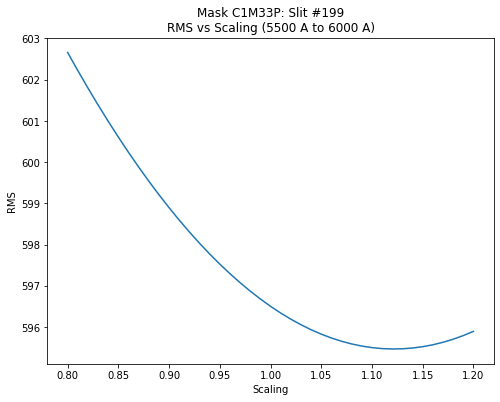

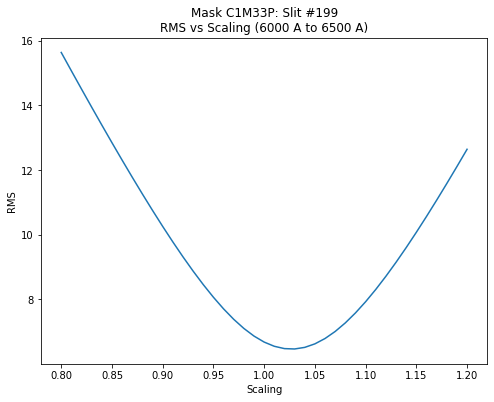

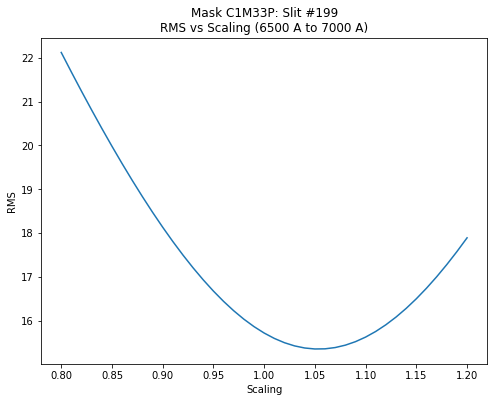

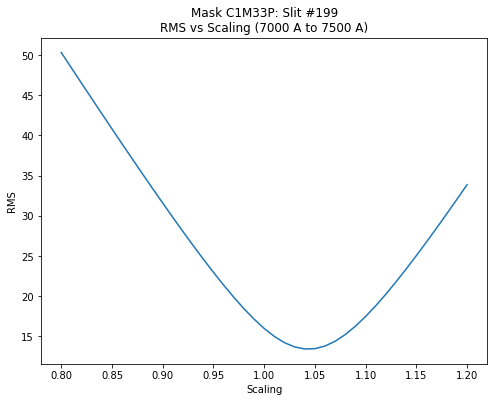

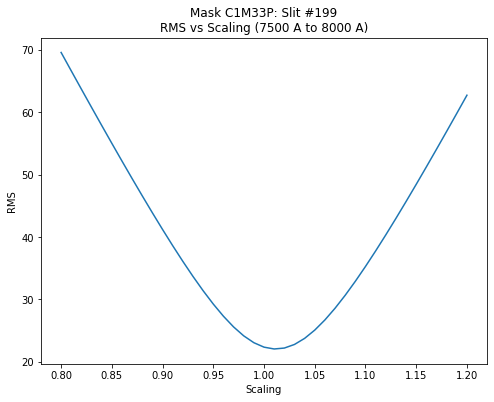

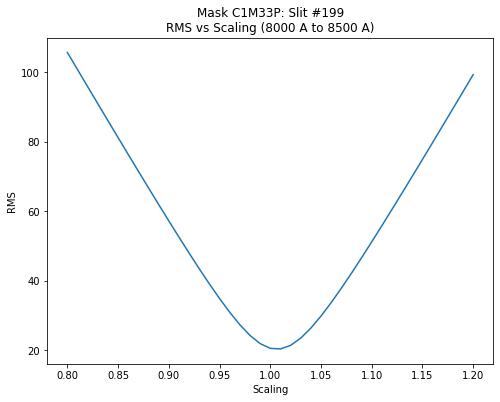

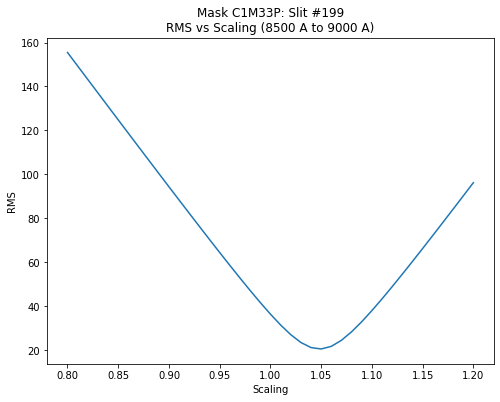

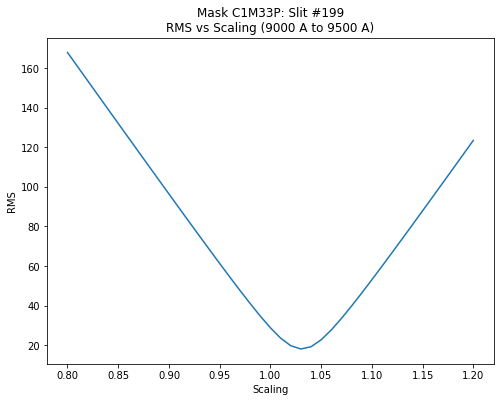

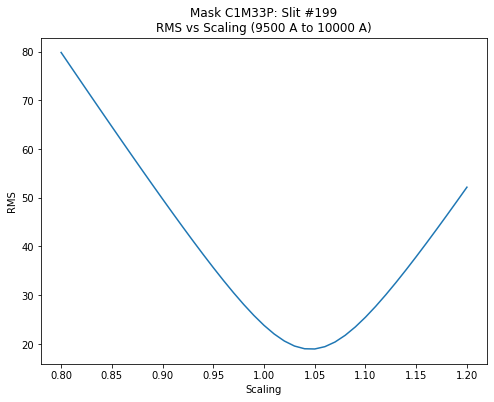

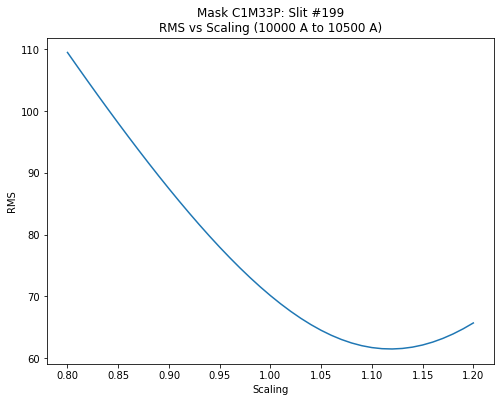

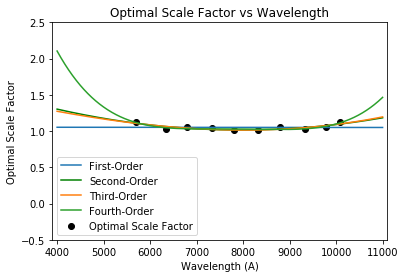

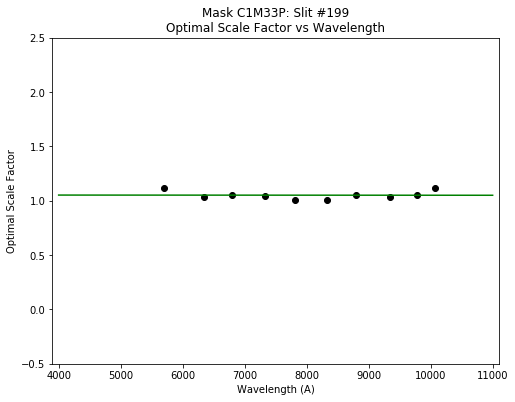

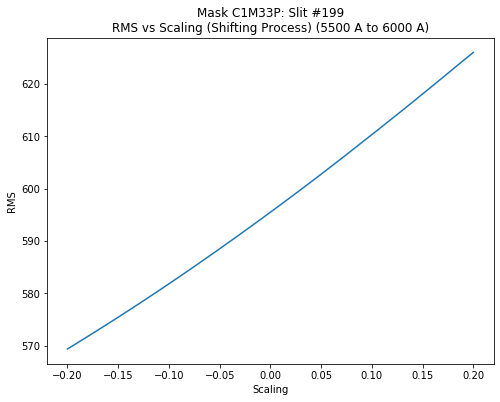

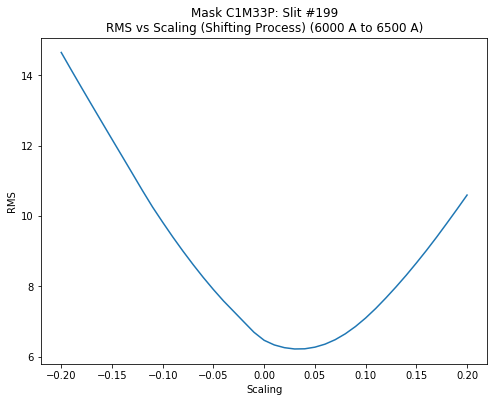

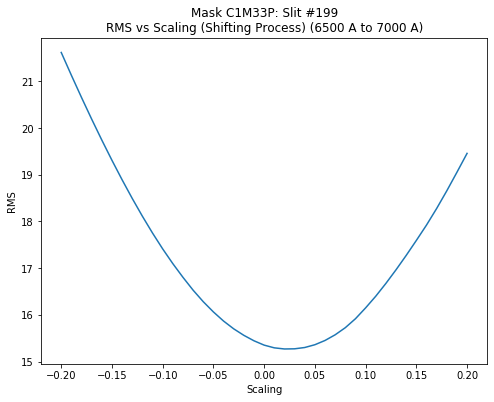

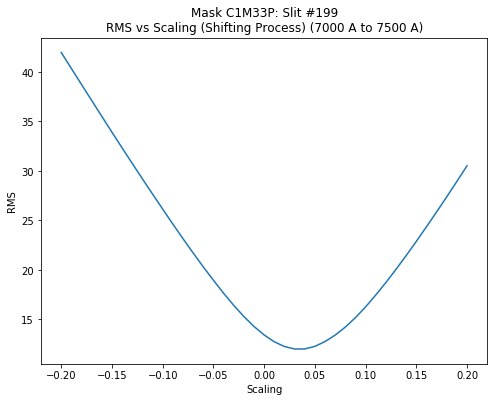

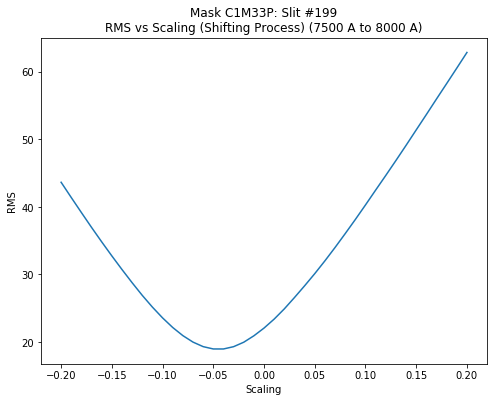

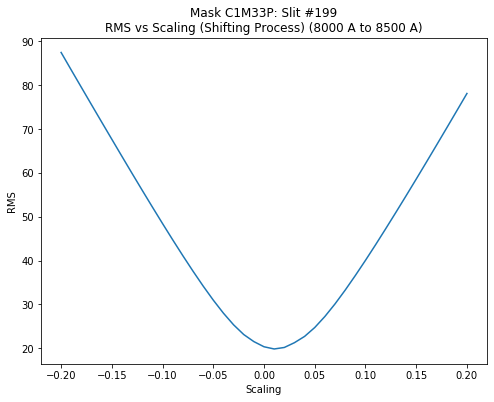

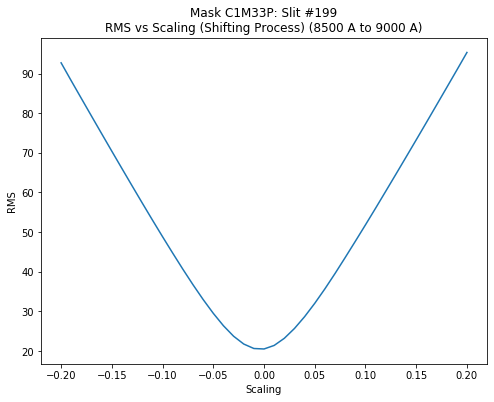

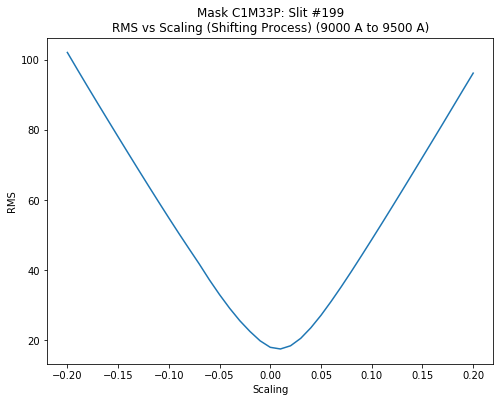

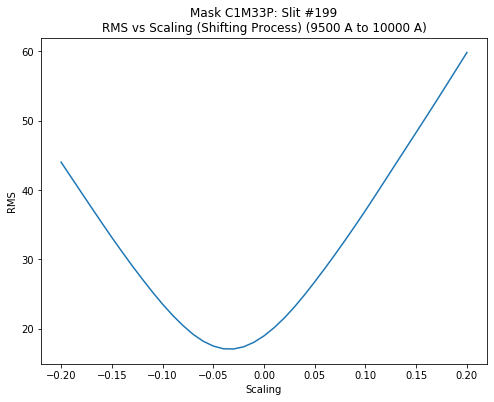

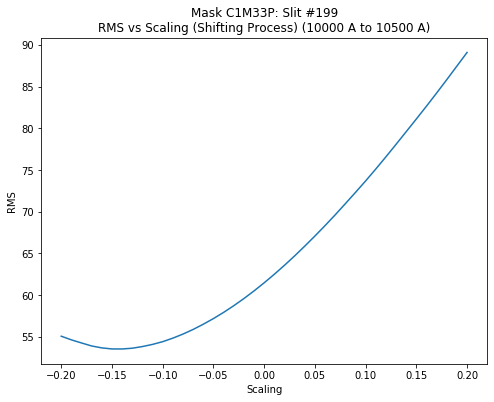

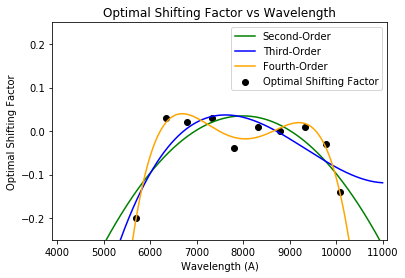

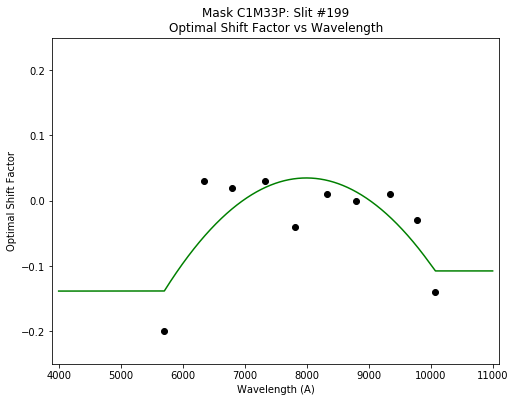

In [173]:
slit_numbers_you_want_to_run_excluded_slits = [199] #put the slit number of all slits you want to iterate

# The text output is written to a log file.
# The log file is overwritten (not appended) every time this cell is executed.
# If you want to keep a record of particular run, make sure you save a copy of the file before running this cell again.
try:
    log_file_exc = open('./C1M33P_Polynomial_Graph/{0}_Excluded_Optimization.log'.format(mask_name), 'w')
    sys.stdout = multifile([ std_out, log_file_exc ])
    sys.stderr = multifile([ std_err, log_file_exc ])
    looping_through_all_function_excluded_slits(slit_numbers_you_want_to_run_excluded_slits)
except Exception as e:
    raise e
finally:
    log_file_exc.close()
    sys.stdout = std_out
    sys.stderr = std_err

## Get Back Scale and Shift Factor

In [89]:
def read_scale_and_shift_factor(mask_name,slit_number_used):
    
    scale_and_shift_factor_hdu = fits.open("{0}_Rebinned/{0}_Scaling_and_Shifting_Factor/Scaling_and_Shifting_Factor_{0}_{1}.fits.gz".format(mask_name,slit_number_used))
    scale_factor = scale_and_shift_factor_hdu[1].data["SCALING_FACTOR"]
    shift_factor = scale_and_shift_factor_hdu[1].data["SHIFTING_FACTOR"]
            
    return scale_factor,shift_factor 

## Rounding Scale and Shift Factor

In [90]:
def rounding_the_factors(scale_factor_list,shift_factor_list):
    
    rounded_scale_factor_list = []
    for value in scale_factor_list:
        rounded_scale_factor_list.append(round(value * 1,2))

    rounded_shift_factor_list = []
    for value in shift_factor_list:
        rounded_shift_factor_list.append(round(value * 1,2))

    return rounded_scale_factor_list, rounded_shift_factor_list

## Get Back Rebinned Flux w/ Shifted Wavelength

In [91]:
def read_rbflux_shifted_wave(mask_name,slit_number_used):
    read_dict = np.load("./{0}_Rebinned/{0}_Rebinned_Flux_Shifted_Wave/rbflux_shifted_dict_{0}_{1}.npy".format(mask_name,slit_number_used),allow_pickle=True).item()
    return read_dict

## Get Back Polynomial Coefficients

In [92]:
def read_poly_coeff(mask_name,slit_number_used):
    
    #get the polynomial coefficients and stores them
    
    poly_coeff = fits.open("{0}_Rebinned/{0}_Polynomial_Coefficients/Poly_Coeff_{0}_{1}.fits.gz".format(mask_name,slit_number_used))
    
    read_poly_coeff_scale = poly_coeff[1].data["POLYNOMIAL_COEFFICIENTS_SCALING"]
    
    read_poly_coeff_shift = poly_coeff[1].data["POLYNOMIAL_COEFFICIENTS_SHIFTING"]
    
    end_values = poly_coeff[1].data["END_VALUES"]
    
    no_outlier_weighted_wave = poly_coeff[1].data["NO_OUTLIER_WEIGHTED_WAVE"]
    
    return read_poly_coeff_scale,read_poly_coeff_shift,end_values,no_outlier_weighted_wave

## Applying the Optimal Shift Factor and Optimal Scale Factor

In [146]:
#Pranav's function use Optimal Scaling Factor and Optimal Shifting Factor to plot 
def plotting_with_shifting_all(index_of_slit,median,rbflux_shifted_dict,rebinned_flux,shifting_values,poly_coeff_scale,end_values,no_outlier_weighted_wave,min_ylim,max_ylim):
    
    wavelength_array = np.arange(4000,11500,500)
    
    new_flux_joined = []

    for index in range(len(wavelength_array)):
        
        if (index + 1) == len(wavelength_array): 
            break
        
        else: 
        
            shifting_factor = shifting_values #list of shifting factors
            
            spectrum = rebinned_flux[index_of_slit] #original rebinned flux 

            #For segments that DOES NOT have Opt Shifting Factor
            if np.isfinite(shifting_values[index]) == False: 
                #new_flux_no_scaling.append(spectrum) 
                fx = np.array(spectrum)
                l = list(fx[np.where((new_wave_600>=wavelength_array[index]) & (new_wave_600<wavelength_array[index+1]))])
                new_flux_joined = new_flux_joined + l
                    
                            
            #For segments that do have Opt Scaling Factor and Opt Shifting Factor
            else: 
                spectrum_shifted = rbflux_shifted_dict["Shifted_{0}".format(shifting_values[index],2)][0]
                #new_flux_no_scaling.append(spectrum_shifted)
                fx = np.array(spectrum_shifted)
                l = list(fx[np.where((new_wave_600>=wavelength_array[index]) & (new_wave_600<wavelength_array[index+1]))])
                new_flux_joined = new_flux_joined + l
    
    all_scale_factors = [] #calculate all the scale factor using polynomial function
    
    for wavelength in new_wave_600:
        if wavelength < min(no_outlier_weighted_wave):
            all_scale_factors.append(end_values[0])
             
        elif wavelength > max(no_outlier_weighted_wave):
            all_scale_factors.append(end_values[1])
        
        else:
            scaling_factor = polynomial_first_order(wavelength,poly_coeff_scale)
            all_scale_factors.append(scaling_factor)
    
    new_rbflux_scaled = (np.array(new_flux_joined) * np.array(all_scale_factors)) - np.array(median)
    
    return new_rbflux_scaled

## Making A New Median

In [94]:
def read_flux_and_wavelength(slit_nums,mask_name):
    
    scaled_original_flux_fits = []
    shifted_original_wavelength_fits = []
    
    for slit_num in slit_nums:
        
        scaled_flux = fits.open("{0}_Rebinned/{0}_Scale_Values/Scale_Values_Polynomial_Fits_{0}_{1}.fits.gz".format(mask_name,slit_num))
        shifted_wavelength = fits.open(("{0}_Rebinned/{0}_Shift_Values/Shift_Values_Polynomial_Fits_{0}_{1}.fits.gz".format(mask_name,slit_num)))
        scaled_original_flux_fits.append(scaled_flux[1].data["ORIGINAL_FLUX_SCALED"])
        shifted_original_wavelength_fits.append(shifted_wavelength[1].data["ORIGINAL_WAVELENGTH_SHIFTED"])
    
    return scaled_original_flux_fits, shifted_original_wavelength_fits

In [95]:
def find_median(rebinned_flux_array):
    
    median_vals = []
    
    print(len(rebinned_flux_array))
    
    for i in range(len(rebinned_flux_array[0])):

        comp = []
        
        for array in rebinned_flux_array:
            
            if np.isfinite(array[i]) == True:
                comp.append(array[i])
                
        median_vals.append(np.median(comp))
        
    return median_vals

In [96]:
scaled_original_flux_fits,shifted_original_wavelength_fits = read_flux_and_wavelength(slit_nums,mask_name)

In [97]:
new_rbflux,new_rbwavelength,new_rbivar = rebin(scaled_original_flux_fits,shifted_original_wavelength_fits,ivar,600)

In [98]:
new_median = find_median(new_rbflux)

73


## Automation of Excluded Slits

In [151]:
def automation_func_exclude(mask_name,slit_number):
    
    #slit number
    slit_number_used = slit_number 
    
    #index of slit number using list of excluded slits 
    index_of_slit = slit_nums_exclude.index(slit_number_used)
    
    #get scale factor and shift factor from FITS files
    scale_factor_list,shift_factor_list = read_scale_and_shift_factor(mask_name,slit_number_used)
    
    #Display whole number, but is actually a float 
    #Round it to whole number 
    rounded_scale_factor_list,rounded_shift_factor_list = rounding_the_factors(scale_factor_list,shift_factor_list)
    
    #Rebinned flux w/ shifted wavelength 
    rbflux_shifted_dict = read_rbflux_shifted_wave(mask_name,slit_number_used)
    
    #Read poly coeff
    poly_coeff_scale,poly_coeff_shift,end_values,no_outlier_weighted_wave = read_poly_coeff(mask_name,slit_number)
    
    #subtraction using new median
    new_flux = plotting_with_shifting_all(index_of_slit,new_median,rbflux_shifted_dict,rbflux_fits_exclude,rounded_shift_factor_list,poly_coeff_scale,end_values,no_outlier_weighted_wave,-500,1000)
    
    return new_flux


In [152]:
def combining_all_exclude_new_flux(mask_name,slit_nums_exclude):
    new_flux_list = []

    for slit_number in slit_nums_exclude:

        new_flux = automation_func_exclude(mask_name,slit_number)

        new_flux_list.append(new_flux)
        
    return new_flux_list

In [153]:
new_flux_list_exclude_slits = combining_all_exclude_new_flux(mask_name,slit_nums_exclude)

## Automation of Included Slits

In [154]:
def automation_func_include(mask_name,slit_number):
    
    #slit number
    slit_number_used = slit_number 
    
    #index of slit number using list of excluded slits 
    index_of_slit = slit_nums.index(slit_number_used)
    
    #get scale factor and shift factor from FITS files
    scale_factor_list,shift_factor_list = read_scale_and_shift_factor(mask_name,slit_number_used)
    
    #Display whole number, but is actually a float 
    #Round it to whole number 
    rounded_scale_factor_list,rounded_shift_factor_list = rounding_the_factors(scale_factor_list,shift_factor_list)
    
    #Rebinned flux w/ shifted wavelength 
    rbflux_shifted_dict = read_rbflux_shifted_wave(mask_name,slit_number_used)
    
    #Read poly coeff
    poly_coeff_scale,poly_coeff_shift,end_values,no_outlier_weighted_wave = read_poly_coeff(mask_name,slit_number)
    
    #subtraction using new median
    new_flux = plotting_with_shifting_all(index_of_slit,new_median,rbflux_shifted_dict,rbflux_fits,rounded_shift_factor_list,poly_coeff_scale,end_values,no_outlier_weighted_wave,-500,1000)
    
    return new_flux

In [155]:
def combining_all_include_new_flux(mask_name,slit_nums):
    new_flux_list = []

    for slit_number in slit_nums:

        new_flux = automation_func_include(mask_name,slit_number)

        new_flux_list.append(new_flux)
        
    return new_flux_list

In [156]:
new_flux_list_include_slits = combining_all_include_new_flux(mask_name,slit_nums)

## Save Optimized Spectrum 

In [157]:
def save_opt_spectrum(opt_spectrum,slit_number,incl_or_excl): #save optimized and trimmed spectrum
    hdu1 = fits.PrimaryHDU()
    
    c1 = fits.Column(name="OPTIMIZED_SPECTRUM", array=opt_spectrum, format="E")
    
    hdu2 = fits.BinTableHDU.from_columns([c1])
    
    hdul = fits.HDUList([hdu1,hdu2])
    
    hdul.writeto("{0}_Trimmed_Spectra/{0}/Optimized_Spectrum_{1}_{2}.fits.gz".format(incl_or_excl,mask_name,slit_number))

## Removing Instrumental Errors

In [158]:
def moving_rms(a, window=50, reverse=False):
    
    '''
    Returns the moving RMS values up to the halfway point of the array
    
    Parameters
    ----------
    a : ndarray
        One dimensional flux array.
    window : int, optional
        The size of each segment for taking the RMS.
    reverse : bool, optional
        Can be used to switch between left-to-right
        and right-to-left directions for the moving RMS.
        Default is left-to-right.
        
    Returns
    ----------
    rms_arr : One dimensional array of moving RMS.
    '''
    
    rms_arr = []
    b = np.where(np.isfinite(a))[0]
    mid_index = int((b[-1]+b[0])/2)
    
    if reverse==False:
        p,q,r = 0,mid_index,1
    else:
        p,q,r = -1,-(len(a)-mid_index-1),-1
    
    for i in range(p,q,r):
        if (reverse==False):
            x = a[i:i+window]
        else:
            x = a[i:i-window:-1]
            
        rms = np.sqrt(np.mean(x**2))
        
        if (reverse==False):
            rms_arr.append(rms)
        else:
            rms_arr.insert(0,rms)

    return np.array(rms_arr)       

In [159]:
def moving_median(a, window=50, reverse=False):
    
    '''
    Returns the moving median values up to the halfway point of the array
    
    Parameters
    ----------
    a : ndarray
        One dimensional flux array.
    window : int, optional
        The size of each segment for taking the median.
    reverse : bool, optional
        Can be used to switch between left-to-right
        and right-to-left directions for the moving median.
        Default is left-to-right.
        
    Returns
    ----------
    median_arr : One dimensional array of moving RMS.
    '''
    
    median_arr = []
    b = np.where(np.isfinite(a))[0]
    mid_index = int((b[-1]+b[0])/2)
    
    if reverse==False:
        p,q,r = 0,mid_index,1
    else:
        p,q,r = -1,-(len(a)-mid_index-1),-1
    
    for i in range(p,q,r):
        if (reverse==False):
            x = a[i:i+window]
        else:
            x = a[i:i-window:-1]
        if np.isfinite(a[i]):
            median = np.median(x[np.where(np.isfinite(x))[0]])
        else:
            median = np.nan
        
        if (reverse==False):
            median_arr.append(median)
        else:
            median_arr.insert(0,median)
    
    return np.array(median_arr)       

In [160]:
# v 11.2

def end_trimming_auto(rbwave, rbflux, left_limit, right_limit, minvalue_l=30, minvalue_r=30, window_l=50, window_r=50, GetBinArray=False):
    
    '''
    \nTrims the instrumental errors at the extreme left and right ends
    of a flux array, using a moving RMS function. Pads the ends with
    NaN to preserve the length of the array.
    
    Version - 11.2
    
    Parameters
    ----------
    rbwave : ndarray
        One dimensional (rebinned) wave array
    rbflux : ndarray
        One dimensional (rebinned) flux array.
    left_limit : int or float, optional
        Size of segment at the left end, within which to look for
        the instrumental effects. The value passed should be in terms
        of wavelength. The function will only look within a range
        of left_limit angstroms, and not any further.
    right_limit : int or float, optional
        Size of segment at the right end, within which to look for
        the instrumental effects. The value passed should be in terms
        of wavelength. The function will only look within a range
        of right_limit angstroms, and not any further.
    minvalue_l : int or float, optional
        Cut-off value at the left end. Flux array is trimmed only when
        the moving RMS value goes below this value at the left end.
    minvalue_r : int or float, optional
        Cut-off value at the right end. Flux array is trimmed when
        the moving RMS value goes below this value at the right end.
    window_l : int or float, optional
        The size of each segment for taking the left-to-right RMS.
    window_r : int or float, optional
        The size of each segment for taking the right-to-left RMS.
    GetBinArray : bool, optional
        Can return the boolean array of indices of the original flux
        array retained after trimming.
        
    Returns
    ----------
    trmdfx : ndaray
        One dimensional array of trimmed flux.
    bin_array : ndarray, only returned if GetBinArray is set to True
        Boolean array of indices retained from original flux array.
        
    Notes
    ----------
    Uses the moving_rms() and moving_median() functions to operate.
    '''
    
    a = np.where(np.isfinite(rbflux))[0] #Fiding the indices of finite flux values
    mid_index = int((a[-1]+a[0])/2)
    b = rbwave[np.isfinite(rbflux)]
    b_l = np.where(rbwave<(b[0]+left_limit))[0]
    left_limit_index = b_l[-1]
    b_r = np.where(rbwave>(b[-1]-right_limit))[0]
    right_limit_index = b_r[0] - len(rbwave)
    
    rms_l = moving_rms(rbflux,window=window_l)
    median_l = np.concatenate((moving_median(rbflux,window=200),np.zeros(len(rbflux)-mid_index)))
    flux_around_median_l = rbflux - median_l
    local_rms_l = moving_rms(flux_around_median_l,window=5)
    
    rms_r = moving_rms(rbflux,window=window_r,reverse=True)
    median_r = np.concatenate((np.zeros(mid_index+2),moving_median(rbflux,window=200,reverse=True)))
    flux_around_median_r = rbflux - median_r
    local_rms_r = moving_rms(flux_around_median_r,window=5,reverse=True)
    
    trmdfx = np.empty_like(rbflux,dtype=float)
    trmdfx[:] = rbflux
    
    #Trimming for the left end...
    for i in range(1,left_limit_index): #Start from 1. Starting from 0 would give IndexError for slope_b
        slope_b = rms_l[i-1]-rms_l[i] #RMS slope b/w this point & previous one. No need to divide by rbwave difference.
        if (rms_l[i]<minvalue_l):
            if (True not in np.isnan(rbflux[i:mid_index])): #Make sure there are no gaps further down
                if (slope_b>0): #Is slope dropping towards mid_index?
                    break
                elif (np.isnan(slope_b)): #Is there NaN before this point? Is this where the finite part begins?
                    break
    
    for k in range(i,left_limit_index):
        local_slope_b = local_rms_l[i-1]-rms_l[i]
        if (np.abs(flux_around_median_l[k])<minvalue_l and local_rms_l[k]<minvalue_l):
            i = k+1
            break
    
    #Trimmming for the right end...
    for j in range(-2,right_limit_index,-1): #Start from -2. Starting from -1 would give IndexError for slope_b
        slope_b = rms_r[j+1]-rms_r[j] #RMS slope b/w this point & previous one. No need to divide by rbwave difference.
        
        if (rms_r[j]<minvalue_r):
            if (True not in np.isnan(rbflux[mid_index:j])): #Make sure there are no gaps further down
                if (slope_b>0): #Is slope dropping towards mid_index?
                    break
                elif (np.isnan(slope_b)): #Is there NaN before this point? Is this where the finite part ends?
                    break

    for k in range(j,right_limit_index,-1):
        if (np.abs(flux_around_median_r[k])<minvalue_r and local_rms_r[k]<minvalue_r):
            j = k-1
            break                    

    bin_array = np.array([True]*len(rbflux))
    bin_array[i:j+1] = False
    trmdfx[bin_array] = np.nan
    
    if GetBinArray==True:
        return(np.array(trmdfx),np.invert(bin_array))
    else:
        return(np.array(trmdfx))

In [161]:
minvalue_l = 30 ; minvalue_r = 50
window_l = 100 ; window_r = 150
left_limit = 1000 ; right_limit = 1000

In [162]:
included_fluxes_dict = {}; included_slits_opt_trimmed_flux_dict = {}
for slit_number in slit_nums:
    new_fx = automation_func_include(mask_name,slit_number)
    included_fluxes_dict[slit_number] = new_fx
    new_fx_trmd,b = end_trimming_auto(rbwave,new_fx,
                                      left_limit,right_limit,
                                      minvalue_l,minvalue_r,
                                      window_l,window_r,
                                      GetBinArray=True)
    included_slits_opt_trimmed_flux_dict[slit_number] = (new_fx_trmd,b)
    print('Done with slit #',slit_number)

Done with slit # 1
Done with slit # 2
Done with slit # 4
Done with slit # 5
Done with slit # 6
Done with slit # 7
Done with slit # 8
Done with slit # 10
Done with slit # 11
Done with slit # 12
Done with slit # 13
Done with slit # 14
Done with slit # 17
Done with slit # 18
Done with slit # 19
Done with slit # 20
Done with slit # 21
Done with slit # 22
Done with slit # 25
Done with slit # 26
Done with slit # 28
Done with slit # 29
Done with slit # 30
Done with slit # 31
Done with slit # 32
Done with slit # 34
Done with slit # 35
Done with slit # 38
Done with slit # 39
Done with slit # 46
Done with slit # 50
Done with slit # 54
Done with slit # 57
Done with slit # 61
Done with slit # 63
Done with slit # 65
Done with slit # 66
Done with slit # 69
Done with slit # 75
Done with slit # 78
Done with slit # 80
Done with slit # 83
Done with slit # 86
Done with slit # 90
Done with slit # 94
Done with slit # 96
Done with slit # 103
Done with slit # 104
Done with slit # 105
Done with slit # 106
Don

In [163]:
excluded_fluxes_dict = {}; excluded_slits_opt_trimmed_flux_dict = {}
for slit_number in slit_nums_exclude:
    new_fx = automation_func_exclude(mask_name,slit_number)
    excluded_fluxes_dict[slit_number] = new_fx
    new_fx_trmd,b = end_trimming_auto(rbwave,new_fx,
                                      left_limit,right_limit,
                                      minvalue_l,minvalue_r,
                                      window_l,window_r,
                                      GetBinArray=True)
    excluded_slits_opt_trimmed_flux_dict[slit_number] = (new_fx_trmd,b)
    print('Done with slit #',slit_number)

Done with slit # 0
Done with slit # 9
Done with slit # 16
Done with slit # 23
Done with slit # 24
Done with slit # 33
Done with slit # 36
Done with slit # 37
Done with slit # 41
Done with slit # 42
Done with slit # 43
Done with slit # 44
Done with slit # 45
Done with slit # 47
Done with slit # 48
Done with slit # 49
Done with slit # 51
Done with slit # 52
Done with slit # 53
Done with slit # 55
Done with slit # 56
Done with slit # 58
Done with slit # 62
Done with slit # 64
Done with slit # 67
Done with slit # 68
Done with slit # 71
Done with slit # 72
Done with slit # 73
Done with slit # 74
Done with slit # 76
Done with slit # 77
Done with slit # 79
Done with slit # 81
Done with slit # 82
Done with slit # 84
Done with slit # 85
Done with slit # 87
Done with slit # 88
Done with slit # 89
Done with slit # 91
Done with slit # 92
Done with slit # 93
Done with slit # 95
Done with slit # 97
Done with slit # 99
Done with slit # 100
Done with slit # 101
Done with slit # 102
Done with slit # 10

In [164]:
print(excluded_slits_opt_trimmed_flux_dict[0])

(array([nan, nan, nan, ..., nan, nan, nan]), array([False, False, False, ..., False, False, False]))


In [165]:
def test_plots(slits,excl_or_incl):

#     rbwave = new_wave_600
    
    if excl_or_incl == 'Excluded':
        opt_flux_dict = excluded_fluxes_dict
        trmd_flux_dict = excluded_slits_opt_trimmed_flux_dict
    elif excl_or_incl == 'Included':
        opt_flux_dict = included_fluxes_dict
        trmd_flux_dict = included_slits_opt_trimmed_flux_dict

    path = './Test Figures/{0}/{1}/'.format(mask_name,excl_or_incl)
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    
    notes_path = "./Raja's notes/{0}_notes.txt".format(mask_name)        
    try:
        with open(notes_path,'r') as f:
            lines = [x.split() for x in f.readlines()]
            notes = {int(x[0]) : ' '.join(x[3:]) for x in lines}
            print_notes = True
    except IOError:
        print_notes = False
    
    plt.ioff()
    for i in slits:
        fig = plt.figure(figsize=(8,6),dpi=600)
        fig.patch.set_alpha(1)
        
        y = opt_flux_dict[i]
        y1,b = trmd_flux_dict[i]
        y2 = np.empty_like(y)
        y2[:] = y; y2[b] = np.nan
#         y5 = moving_median(y,window=200)
#         y6 = moving_median(y,window=200,reverse=True)
#         y3_ = y-np.concatenate((y5,np.array([np.nan]),np.zeros(len(y)-len(y5)-1)))
#         y3 = moving_rms(y,window=window_l)
#         y4_ = y-np.concatenate((np.zeros(len(y)-len(y6)-1),np.array([np.nan]),y6))
#         y4 = moving_rms(y,window=window_r,reverse=True)
#         y8 = np.median(y[np.isfinite(y)])*np.ones(len(y))[b]

        plt.plot(rbwave,y1,'dodgerblue',ls='-',label='Part retained')
        plt.plot(rbwave,y2,'red',ls='-',label='Part trimmed')
#         plt.plot(rbwave[0:len(y5)],y5,'limegreen',ls=':',lw=0.6,label='Moving median (L-R)')
#         plt.plot(rbwave[-len(y6)-1:-1],y6,'brown',ls=':',lw=0.6,label='Moving median (R-L)')
#         plt.plot(rbwave[0:len(y3)],y3,'blue',ls='-',lw=0.8,label='Moving RMS (L-R)')
#         plt.plot(rbwave[-len(y4)-1:-1],y4,'gold',ls='-',lw=0.8,label='Moving RMS (R-L)')
#         plt.plot(rbwave[b],y8,'darkorange',ls=':',lw=0.5,label='Median of whole flux array')
        plt.xlabel("Wavelength (A)")
        plt.ylabel("Flux (Electron/Hour)")
#         plt.title('Trimming function version 11.2')
        plt.legend()
        
        plt.suptitle('Test figure: slit #{0} in mask {1} ({2})'.format(i,mask_name,excl_or_incl),fontsize=18)
        if (print_notes == True):
            txt = 'Notes: {0}'.format(notes[i])
            plt.figtext(0.95, 0.08, txt, alpha=0.5, wrap=True, ha='right', va='top', fontstyle='italic', fontsize=8)
            plt.tight_layout(rect=[0,0.1,0.9,1])
        s = 'test_figure_{0}_slit_{1}.png'.format(mask_name,i)
        plt.savefig(path+s)
        print('Saved figure {0}'.format(s))
        plt.close('all')
    plt.ion()

In [166]:
test_plots(slit_nums,"Included")

Saved figure test_figure_C1M33P_slit_1.png
Saved figure test_figure_C1M33P_slit_2.png
Saved figure test_figure_C1M33P_slit_4.png
Saved figure test_figure_C1M33P_slit_5.png
Saved figure test_figure_C1M33P_slit_6.png
Saved figure test_figure_C1M33P_slit_7.png
Saved figure test_figure_C1M33P_slit_8.png
Saved figure test_figure_C1M33P_slit_10.png
Saved figure test_figure_C1M33P_slit_11.png
Saved figure test_figure_C1M33P_slit_12.png
Saved figure test_figure_C1M33P_slit_13.png
Saved figure test_figure_C1M33P_slit_14.png
Saved figure test_figure_C1M33P_slit_17.png
Saved figure test_figure_C1M33P_slit_18.png
Saved figure test_figure_C1M33P_slit_19.png
Saved figure test_figure_C1M33P_slit_20.png
Saved figure test_figure_C1M33P_slit_21.png
Saved figure test_figure_C1M33P_slit_22.png
Saved figure test_figure_C1M33P_slit_25.png
Saved figure test_figure_C1M33P_slit_26.png
Saved figure test_figure_C1M33P_slit_28.png
Saved figure test_figure_C1M33P_slit_29.png
Saved figure test_figure_C1M33P_slit_30

In [167]:
test_plots(slit_nums_exclude,"Excluded")

Saved figure test_figure_C1M33P_slit_0.png
Saved figure test_figure_C1M33P_slit_9.png
Saved figure test_figure_C1M33P_slit_16.png
Saved figure test_figure_C1M33P_slit_23.png
Saved figure test_figure_C1M33P_slit_24.png
Saved figure test_figure_C1M33P_slit_33.png
Saved figure test_figure_C1M33P_slit_36.png
Saved figure test_figure_C1M33P_slit_37.png
Saved figure test_figure_C1M33P_slit_41.png
Saved figure test_figure_C1M33P_slit_42.png
Saved figure test_figure_C1M33P_slit_43.png
Saved figure test_figure_C1M33P_slit_44.png
Saved figure test_figure_C1M33P_slit_45.png
Saved figure test_figure_C1M33P_slit_47.png
Saved figure test_figure_C1M33P_slit_48.png
Saved figure test_figure_C1M33P_slit_49.png
Saved figure test_figure_C1M33P_slit_51.png
Saved figure test_figure_C1M33P_slit_52.png
Saved figure test_figure_C1M33P_slit_53.png
Saved figure test_figure_C1M33P_slit_55.png
Saved figure test_figure_C1M33P_slit_56.png
Saved figure test_figure_C1M33P_slit_58.png
Saved figure test_figure_C1M33P_sl

## Reading Optimized Spectrum

In [ ]:
def read_optimized_data(mask_name, file_names):
        
    spectrum = []
        
    for slit in file_names: 
        spectrum_data_slit = fits.open(path_name + "/{0}_Trimmed_Spectra/Optimized_Spectrum_Flux/Optimized_Spectrum_{0}_{1}.fits.gz".format(mask_name,slit))
        spectrum.append(spectrum_data_slit[1].data["OPTIMIZED_SPECTRUM"])
            
    return spectrum   

## Plot one slit with emission lines

In [ ]:
def emission_lines():
    filepath = 'optical_linelist.dat.txt'
    fp = open(filepath)
    all_emission_lines = []
    is_first_line = True
    for line in (fp):
        emission_line = line.split()[1]
        all_emission_lines.append(emission_line)
    
    
    all_emission_lines.pop(0)
    
    
    return all_emission_lines

In [ ]:
def plot_with_emission_lines(slit_number, min_ylim=-300, max_ylim=700, min_xlim=4000, max_xlim=11000):
    
    spectrum = read_optimized_data(mask_name, all_slit_nums)
    
    slit_index = all_slit_nums.index(slit_number)
    
    all_emission_lines = emission_lines()
    
    plt.ylim(min_ylim,max_ylim) 
    plt.xlim(min_xlim,max_xlim)
    plt.xlabel("Wavelength (A)")
    plt.ylabel("Flux (Electron/Hour)")
    plt.title("Slit {0} ({1} A to {2} A)".format(slit_number, min_xlim, max_xlim))
    
    plt.plot(rbwave,spectrum[slit_index])
    for line in all_emission_lines:
        plt.axvline(float(line), min_ylim, max_ylim, c = "r")

In [ ]:
# plot_with_emission_lines(5, -300, 700, 6200, 6400)
plot_with_emission_lines()